##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bayesian Modeling with Joint Distribution

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Modeling_with_JointDistribution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

`JointDistributionSequential` is a newly introduced distribution-like Class that empowers users to fast prototype Bayesian model. It lets you chain multiple distributions together, and use lambda function to introduce dependencies. This is designed to build small- to medium- size Bayesian models, including many commonly used models like GLMs, mixed effect models, mixture models, and more. It enables all the necessary features for a Bayesian workflow: prior predictive sampling,  It could be plug-in to another larger Bayesian Graphical model or neural network. In this Colab, we will show some examples of how to use `JointDistributionSequential` to achieve your day to day Bayesian workflow


### Dependencies & Prerequisites


In [0]:
#@title Install { display-mode: "form" }
TF_Installation = 'TF2 Nightly (GPU)' #@param ['TF2 Nightly (GPU)', 'TF2 Stable (GPU)', 'TF1 Nightly (GPU)', 'TF1 Stable (GPU)','System']

if TF_Installation == 'TF2 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu-2.0-preview
  print('Installation of `tf-nightly-gpu-2.0-preview` complete.')
elif TF_Installation == 'TF2 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
  print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')
elif TF_Installation == 'TF1 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu
  print('Installation of `tf-nightly-gpu` complete.')
elif TF_Installation == 'TF1 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu
  print('Installation of `tensorflow-gpu` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [0]:
#@title Install { display-mode: "form" }
TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [0]:
#@title Import and set ups{ display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [0]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

## JointDistribution

Notes: This distribution class is useful when you just have a simple model. "Simple" means chain-like graphs; although the approach technically works for any PGM with degree at most 255 for a single node (Because Python functions can have at most this many args).

The basic idea is to have the user specify a list of `callable`s which produce `tfp.Distribution` instances, one for every vertex in their [PGM](https://en.wikipedia.org/wiki/Graphical_model). The `callable` will have at most as many arguments as its index in the list. (For user convenience, aguments will be passed in reverse order of creation.)  Internally we'll "walk the graph" simply by passing every previous RV's value into each callable. In so doing we implement the [chain rule of probablity](https://en.wikipedia.org/wiki/Chain_rule_(probability%29#More_than_two_random_variables): $p(\{x\}_i^d)=\prod_i^d p(x_i|x_{<i})$.

The idea is pretty simple, even as Python code. Here's the gist:

```python
# The chain rule of probability, manifest as Python code.
def log_prob(rvs, xs):
  # xs[:i] is rv[i]'s maximal blanket. `[::-1]` just reverses the list.
  return sum(rv(*xs[i-1::-1]).log_prob(xs[i])
             for i, rv in enumerate(rvs))
```

You can find more information from the docstring of `JointDistributionSequential`, but the gist is that you pass a list of distributions to initialize the Class, if some distributions in the list is depending on output from another upstream distribution/variable, you just wrap it with a lambda function. Now let's see how it works in action!

## (Robust) Linear regression

From PyMC3 doc [GLM: Robust Regression with Outlier Detection](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html)

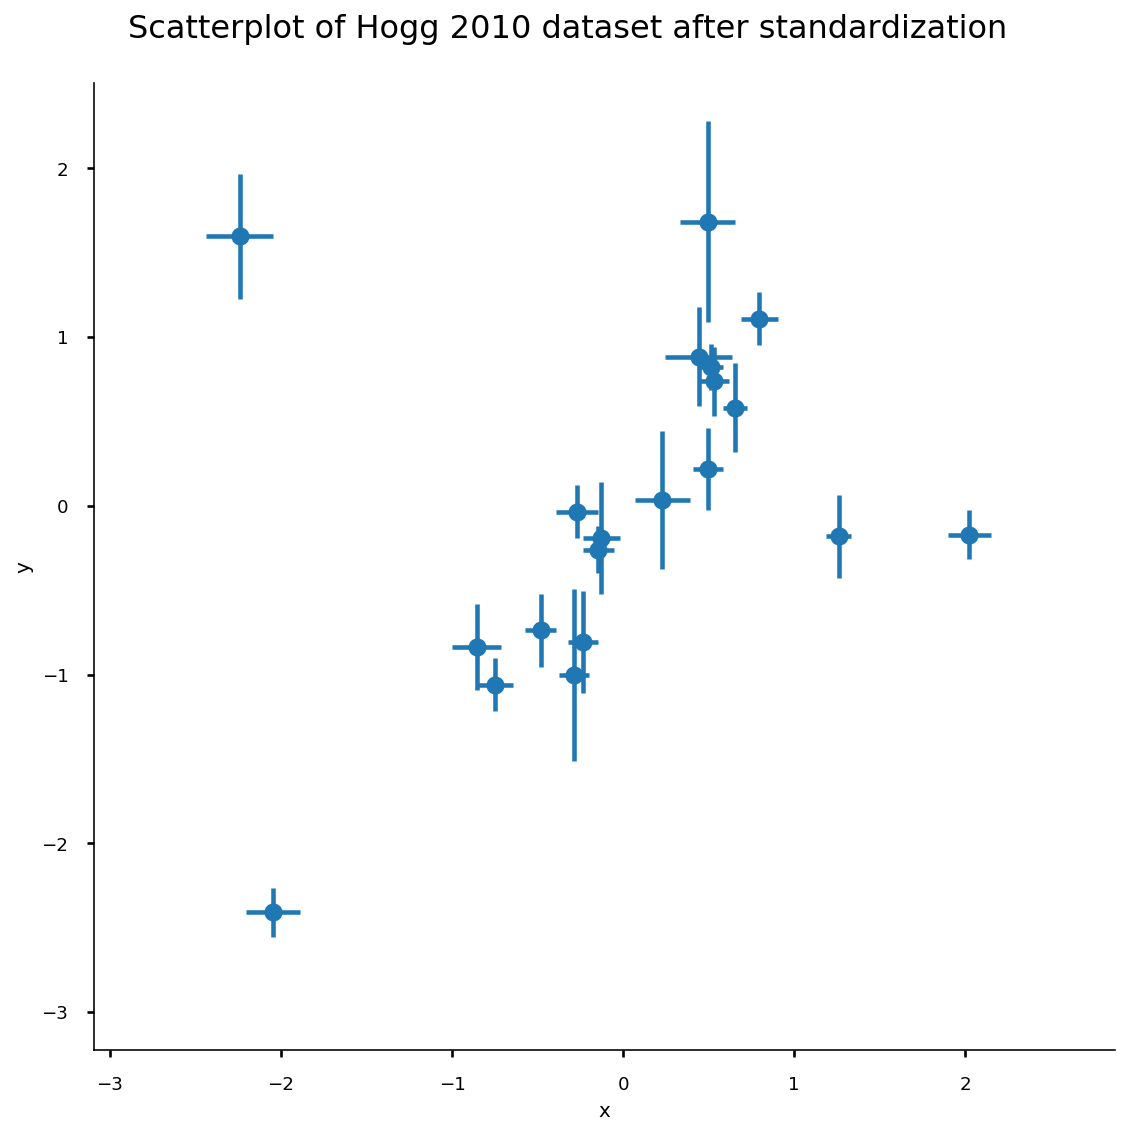

In [0]:
#@title Get data
#@markdown Cut & pasted directly from the `fetch_hogg2010test()` function. It is identical to the original dataset as hardcoded in the Hogg 2010 paper
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

def plot_hoggs(dfhoggs):
  ## create xlims ylims for plotting
  xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5,
           dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
  ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5,
           dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

  ## scatterplot the standardized data
  g = sns.FacetGrid(dfhoggs, size=8)
  _ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
  _ = g.axes[0][0].set_ylim(ylims)
  _ = g.axes[0][0].set_xlim(xlims)

  plt.subplots_adjust(top=0.92)
  _ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)
  return g, xlims, ylims
  
g = plot_hoggs(dfhoggs)

In [0]:
X_np = dfhoggs['x'].values
sigma_y_np = dfhoggs['sigma_y'].values
Y_np = dfhoggs['y'].values

### Conventional OLS Model
Now, let's set up a linear model, a simple intercept + slope regression problem:

In [0]:
mdl_ols = tfd.JointDistributionSequential([
    # b0 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # x ~ Normal(b0+b1*X, 1)
    lambda b1, b0: tfd.Normal(
      # Parameter transformation
      loc=b0 + b1*X_np,
      scale=sigma_y_np)
])

You can then check the graph of the model to see the dependence.

In [0]:
mdl_ols._resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

Sampling from the model is quite straightforward:

In [0]:
mdl_ols.sample()

(<tf.Tensor: id=28, shape=(), dtype=float64, numpy=-0.50225804634794>,
 <tf.Tensor: id=50, shape=(), dtype=float64, numpy=0.682740126293564>,
 <tf.Tensor: id=77, shape=(20,), dtype=float64, numpy=
 array([-0.33051382,  0.71443618, -1.91085683,  0.89371173, -0.45060957,
        -1.80448758, -0.21357082,  0.07891058, -0.20689721, -0.62690385,
        -0.55225748, -0.11446535, -0.66624497, -0.86913291, -0.93605552,
        -0.83965336, -0.70988597, -0.95813437,  0.15884761, -0.31113434])>)

...which gives a tuple of tf.Tensor. You can immediately plug it into the log_prob function to compute the log_prob of the model:

In [0]:
b0, b1, y = mdl_ols.sample()
mdl_ols.log_prob([b0, b1, y])

<tf.Tensor: id=188, shape=(20,), dtype=float64, numpy=
array([-4.97502846, -3.98544303, -4.37514505, -3.46933487, -3.80688125,
       -3.42907525, -4.03263074, -3.3646366 , -4.70370938, -4.36178501,
       -3.47823735, -3.94641662, -5.76906319, -4.0944128 , -4.39310708,
       -4.47713894, -4.46307881, -3.98802372, -3.83027747, -4.64777082])>

Hmmm, something is not right here: we should be getting a scalar log_prob! In fact, we can further check to see if something is off by calling the `.log_prob_parts`, which gives the `log_prob` of each nodes in the Graphical model:

In [0]:
mdl_ols.log_prob_parts([b0, b1, y])

(<tf.Tensor: id=203, shape=(), dtype=float64, numpy=-0.9699239562734849>,
 <tf.Tensor: id=212, shape=(), dtype=float64, numpy=-3.459364167569284>,
 <tf.Tensor: id=221, shape=(20,), dtype=float64, numpy=
 array([-0.54574034,  0.4438451 ,  0.05414307,  0.95995326,  0.62240687,
         1.00021288,  0.39665739,  1.06465152, -0.27442125,  0.06750311,
         0.95105078,  0.4828715 , -1.33977506,  0.33487533,  0.03618104,
        -0.04785082, -0.03379069,  0.4412644 ,  0.59901066, -0.2184827 ])>)

...turns out the last node is not being reduce_sum along the i.i.d. dimension/axis! The trick here is to use `tfd.Independent` to reinterpreted the batch shape (so that the rest of the axis will be reduced correctly):

In [0]:
mdl_ols_ = tfd.JointDistributionSequential([
    # b0
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda b1, b0: tfd.Independent(
        tfd.Normal(
            # Parameter transformation
            loc=b0 + b1*X_np,
            scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    ),
])

Now, lets check the last node/distribution of the model, you can see that event shape is now correctly interpreted. Note that it might take a bit of trial and error to get the `reinterpreted_batch_ndims` right, but you can always easily print the distribution or sampled tensor to double check the shape!

In [0]:
print(mdl_ols_.sample_distributions()[0][-1])
print(mdl_ols.sample_distributions()[0][-1])

tfp.distributions.Independent("IndependentJointDistributionSequential/sample_distributions/Normal/", batch_shape=(), event_shape=(20,), dtype=float64)
tfp.distributions.Normal("JointDistributionSequential/sample_distributions/Normal/", batch_shape=(20,), event_shape=(), dtype=float64)


In [0]:
b0, b1, y = mdl_ols_.sample()
mdl_ols_.log_prob([b0, b1, y])  # <== Getting a scalar correctly

<tf.Tensor: id=518, shape=(), dtype=float64, numpy=-2.5434256610132864>

And we can now do inference! You can use optimizer to find the Maximum likelihood estimation. 

#### MLE

In [0]:
# Small wrapper to get the neg_log_likelihood that outputs value with gradient
def neg_log_likelihood(x):
  def neg_log_p(x):
    return -tf.squeeze(mdl_ols_.log_prob([x[0], x[1], Y_np]))
  return tfp.math.value_and_gradient(neg_log_p, x)

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=tf.zeros(2, dtype=dtype),
    tolerance=1e-20,
    x_tolerance=1e-8
)

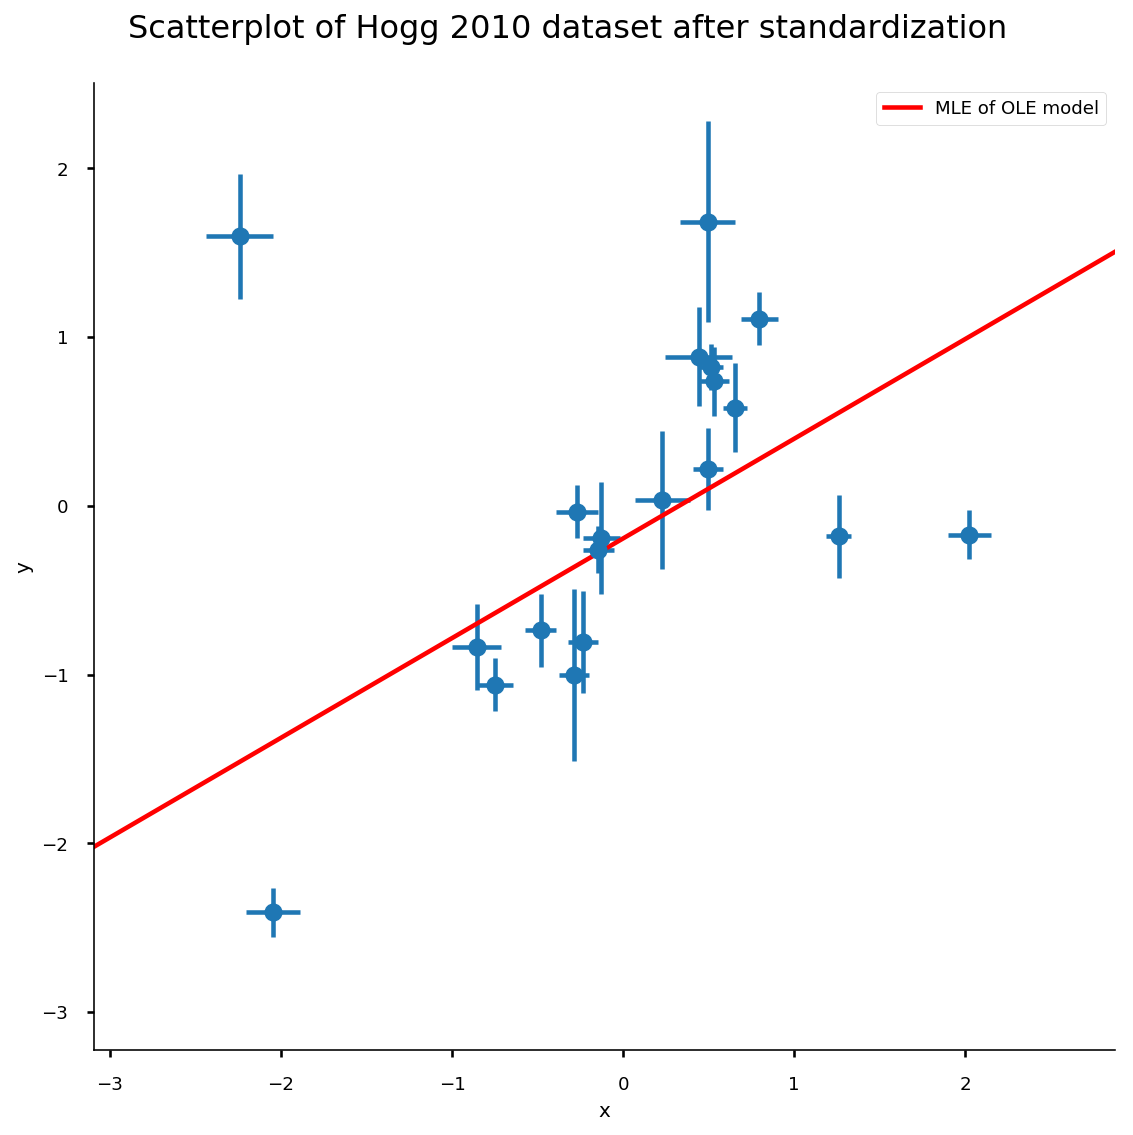

In [0]:
b0est, b1est = lbfgs_results.position.numpy()

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, 
                  color='r', label='MLE of OLE model')
plt.legend();

#### Batched version model and MCMC

In Bayesian Inference, we usually want to work with MCMC samples, as when the samples are from the posterior, we can plug them into *any* function to compute expectations. However, the MCMC API require us to write models that are batch friendly, and we can check that our model is actually not "batchable" by calling `sample([...])`

```python
mdl_ols_.sample(5)  # <== error as some computation could not be done in batch
```

In this case, it is relatively straightforward as we only have a linear function inside our model, expanding the shape should do the trick:

In [0]:
mdl_ols_batch = tfd.JointDistributionSequential([
    # b0
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda b1, b0: tfd.Independent(
        tfd.Normal(
            # Parameter transformation
            loc=b0[:, None] + b1[:, None]*X_np[None, :],
            scale=sigma_y_np[None, :]),
        reinterpreted_batch_ndims=1
    ),
])

mdl_ols_batch._resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

We can again sample and evaluate the log_prob_parts to do some checks:

In [0]:
mdl_ols_batch.sample_distributions(4)

((<tfp.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float64>,
  <tfp.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float64>,
  <tfp.distributions.Independent 'IndependentJointDistributionSequential/sample_distributions/Normal/' batch_shape=(4,) event_shape=(20,) dtype=float64>),
 (<tf.Tensor: id=3210, shape=(4,), dtype=float64, numpy=array([-0.2310448 ,  0.87749748, -0.46352668, -0.68479255])>,
  <tf.Tensor: id=3234, shape=(4,), dtype=float64, numpy=array([-2.04711591,  0.90778421,  0.87343707, -0.67425712])>,
  <tf.Tensor: id=3285, shape=(4, 20), dtype=float64, numpy=
  array([[-1.44997787, -3.20427944,  4.21622242, -4.28830315, -1.53586846,
           3.95674856, -1.59326245, -1.42020029, -1.2601087 ,  0.30570741,
           0.08419579, -1.58253604,  1.11153852,  1.19977834, -0.12245731,
          -0.51068526, -0.75295531,  1.89393561, -1.5389157 ,  0.4965925 ],
         [ 1.06716791,  1.65613038, -1.42590527,  2.50937218,  1.40079363,
     

In [0]:
b0, b1, y = mdl_ols_batch.sample(4)
mdl_ols_batch.log_prob_parts([b0, b1, y])

(<tf.Tensor: id=3413, shape=(4,), dtype=float64, numpy=array([-1.15995021, -1.0486493 , -1.10700169, -0.92724043])>,
 <tf.Tensor: id=3422, shape=(4,), dtype=float64, numpy=array([-1.0005514 , -1.22588719, -0.93459692, -1.06544488])>,
 <tf.Tensor: id=3433, shape=(4,), dtype=float64, numpy=array([-1.74732094, -2.35175046,  0.8867087 ,  1.93450759])>)

Some side notes:
- Now `mdl_ols_batch.sample()` would not work as the model is expecting inputs to be tensors with a batch dimension. You can do `mdl_ols_batch.sample()` and squeeze the output (value or log_prob) as a workaround.
- We want to work with batch version of the model because it is the fastest for multi-chain MCMC. In cases that you cannot rewrite the model as a batched version (e.g., ODE models), you can map the log_prob function using `tf.map_fn` to achieve the same effect.

In [0]:
# Small helper function to validate log_prob shape (avoid wrong broadcasting)
def validate_log_prob_part(model, batch_shape=1, observed=-1):
  samples = model.sample(batch_shape)
  logp_part = list(model.log_prob_parts(samples))
  
  # exclude observed node
  logp_part.pop(observed)
  for part in logp_part:
    tf.assert_equal(part.shape, logp_part[-1].shape)

validate_log_prob_part(mdl_ols_batch, 4)

In [0]:
#@title More checks: comparing the generated log_prob fucntion with handwrittent TFP log_prob function. { display-mode: "form" }

def ols_logp_batch(b0, b1, Y):
  b0_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.) # b0
  b1_prior = tfd.Normal(loc=tf.cast(0, dtype), scale=1.) # b1
  likelihood = tfd.Normal(loc=b0[:, None] + b1[:, None]*X_np[None, :],
                          scale=sigma_y_np[None, :]) # likelihood
  return b0_prior.log_prob(b0) +\
         b1_prior.log_prob(b1) +\
         tf.reduce_sum(likelihood.log_prob(Y), axis=-1)

b0, b1, x = mdl_ols_batch.sample(4)
print(mdl_ols_batch.log_prob([b0, b1, Y_np]).numpy()) 
print(ols_logp_batch(b0, b1, Y_np).numpy())

[-207.40400167 -163.0159477  -980.88231646 -694.09693588]
[-207.40400167 -163.0159477  -980.88231646 -694.09693588]


#### MCMC

In [0]:
logp = lambda b0, b1: mdl_ols_batch.log_prob([b0, b1, Y_np])


@tf.function(autograph=False)
def run_chain(number_of_steps = 1000, burnin = 1000, nchain = 4):
  b0, b1, _ = mdl_ols_batch.sample(nchain)

  def trace_fn(_, pkr):
    return (pkr.inner_results.is_accepted,
            pkr.inner_results.accepted_results.step_size)

  hmc=tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=logp,
      num_leapfrog_steps=3,
      step_size=[tf.cast(i, dtype=dtype) for i in [.1, .1]]),
      target_accept_prob=tf.cast(.8, dtype=dtype),
      # Adapt for the entirety of the trajectory.
      num_adaptation_steps=burnin
      )

  # Sampling from the chain.
  mcmc_trace, (is_accepted, step_size) = tfp.mcmc.sample_chain(
      num_results = number_of_steps,
      num_burnin_steps = burnin,
      current_state=[b0, b1],
      kernel=hmc,
      trace_fn=trace_fn)
  return mcmc_trace, is_accepted, step_size


# Sample from posterior distribution and get diagnostic
mcmc_trace, is_accepted, step_size = run_chain()
ess = tfp.mcmc.effective_sample_size(mcmc_trace)
rhat = tfp.mcmc.potential_scale_reduction(mcmc_trace)

In [0]:
print("acceptance rate: {}".format(is_accepted.numpy().mean()))
print("final 100 step size: {}".format(np.asarray(step_size[-100:]).mean(-1)))
print("The effective sample size is: ")
print(np.asarray(ess))
print("The rhat is: ")
print(np.asarray(rhat))

acceptance rate: 0.77625
final 100 step size: [0.05615137 0.05615137]
The effective sample size is: 
[[1000. 1000. 1000. 1000.]
 [1000. 1000. 1000. 1000.]]
The rhat is: 
[1.00125496 1.00044043]


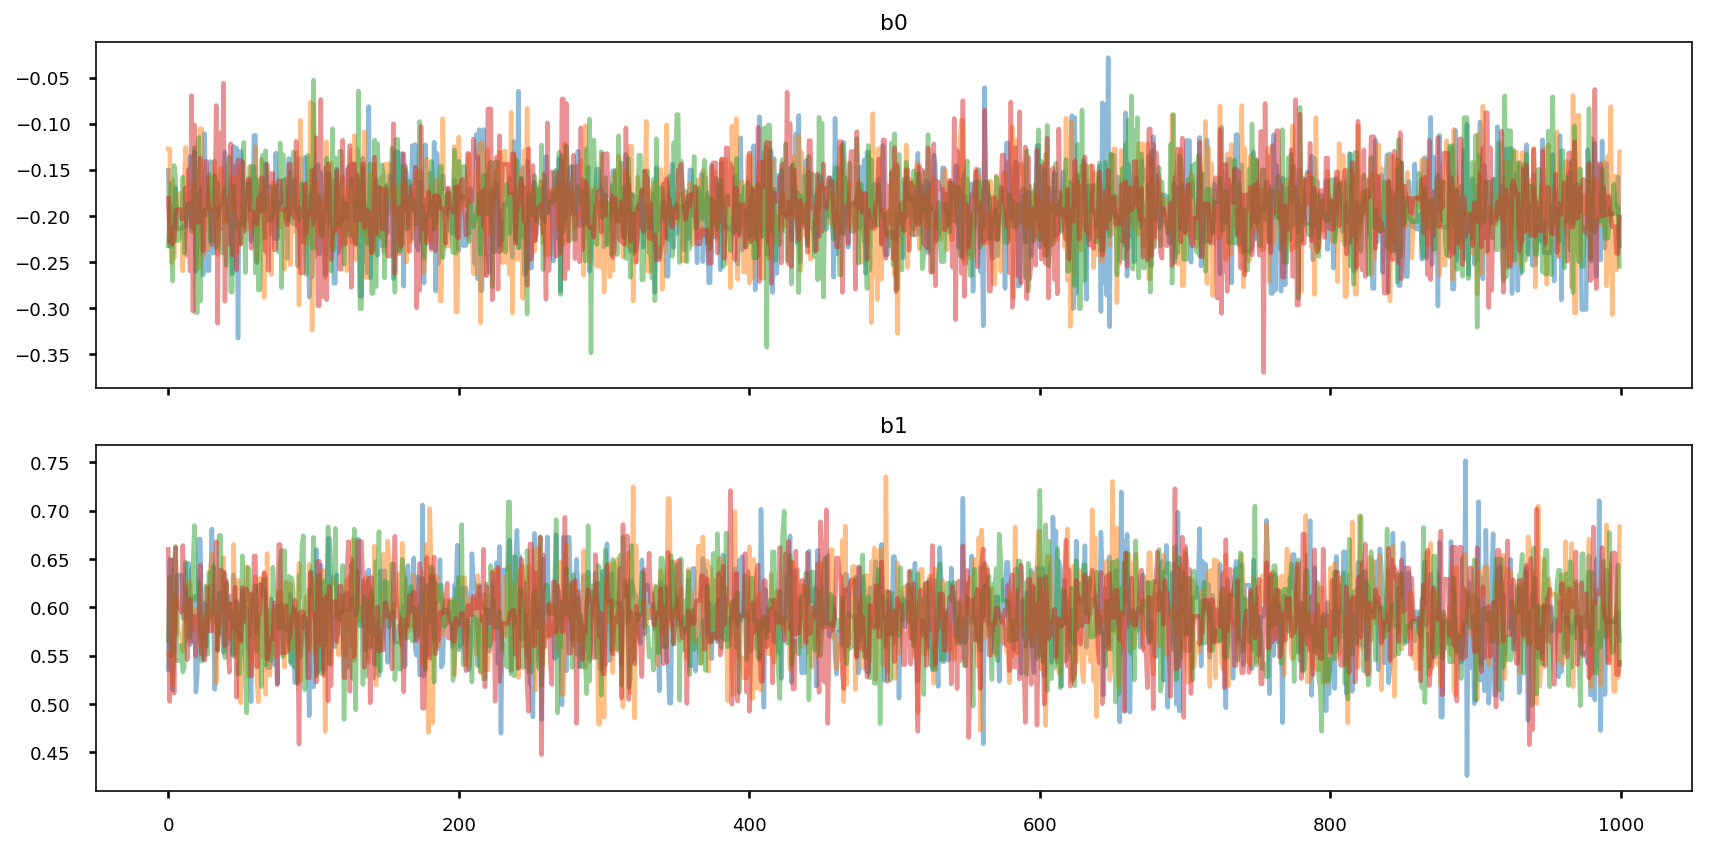

In [0]:
var_name = ['b0', 'b1']
n_var = len(mcmc_trace)
_, ax = plt.subplots(n_var, 1, figsize=(12, 3*n_var), sharex=True)
for i in range(n_var):
  ax[i].plot(mcmc_trace[i].numpy().squeeze(), alpha=.5)
  ax[i].set_title(var_name[i])
plt.tight_layout();

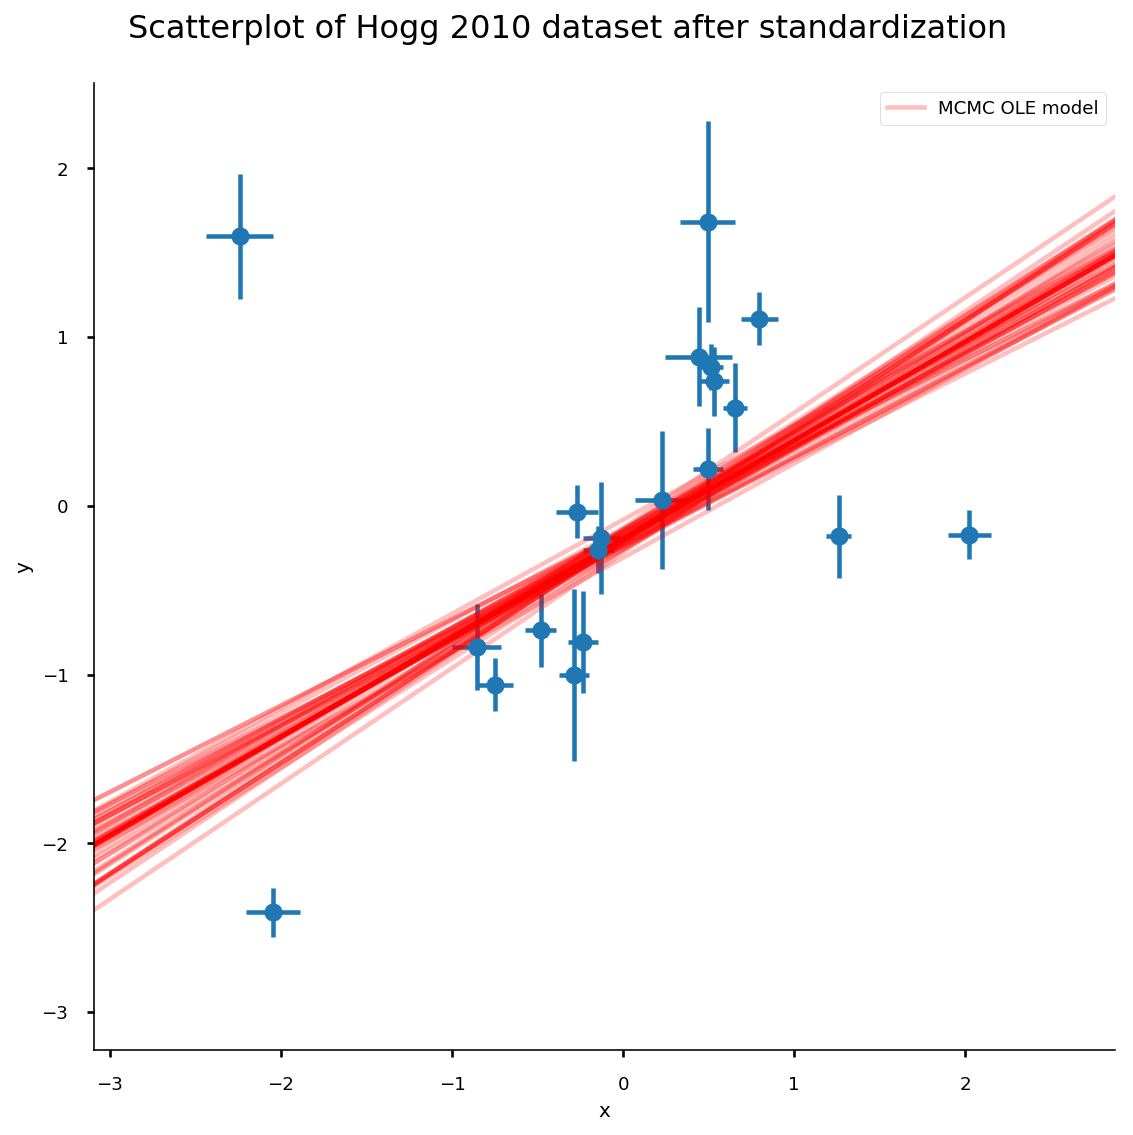

In [0]:
k = 50
b0est, b1est = mcmc_trace[0].numpy().flatten()[-k:, None], mcmc_trace[1].numpy().flatten()[-k:, None]

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)[None, :]
g.axes[0][0].plot(np.tile(xrange, (k, 1)).T,
                  (b0est + b1est*xrange).T,
                  alpha=.25, color='r')
plt.legend([g.axes[0][0].lines[-1]], ['MCMC OLE model']);

### Student-T Method

Note that from now on we always work with the batch version of a model

In [0]:
a, b = tf.cast(1., dtype), tf.cast(100., dtype)
mdl_studentt = tfd.JointDistributionSequential([
    # b0 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # df ~ Uniform(a, b)
    tfd.Uniform(low=a, high=b), # df
    # likelihood ~ StudentT(df, f(b0, b1), sigma_y)
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted,
    #   Note also the use of boilerplate [:, None] to make sure correct shape.
    lambda df, b1, b0: tfd.Independent(
        tfd.StudentT(
            df=df[:, None],
            # Parameter transformation
            loc=b0[:, None] + b1[:, None]*X_np[None, :],
            scale=sigma_y_np[None, :])), # likelihood
])

mdl_studentt._resolve_graph()

(('b0', ()), ('b1', ()), ('df', ()), ('x', ('df', 'b1', 'b0')))

In [0]:
validate_log_prob_part(mdl_studentt, 4)

#### Forward sample (prior predictive sampling)

In [0]:
b0, b1, df, x = mdl_studentt.sample(1000)
x.shape

TensorShape([1000, 20])

#### MLE

In [0]:
# Interval transformation
tfp_interval = tfb.Inline(
    inverse_fn=(
        lambda x: tf.math.log(x - a) - tf.math.log(b - x)),
    forward_fn=(
        lambda y: (b - a) * tf.sigmoid(y) + a),
    forward_log_det_jacobian_fn=(
        lambda x: tf.math.log(b - a) - 2 * tf.nn.softplus(-x) - x),
    forward_min_event_ndims=0,
    name="interval")

# Now that we have a batch version of log_prob function, reduce_sum is needed
neg_log_p = lambda x: -tf.reduce_sum(mdl_studentt.log_prob(
             [[x[0]], [x[1]], [tfp_interval.inverse(x[2])], Y_np]))

def neg_log_likelihood(x):
  return tfp.math.value_and_gradient(neg_log_p, x)


start = tf.cast(
    [0., 0., tfp_interval.forward(np.float64(2.))],
    dtype=dtype)

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=start,
    tolerance=1e-20,
    x_tolerance=1e-20
)

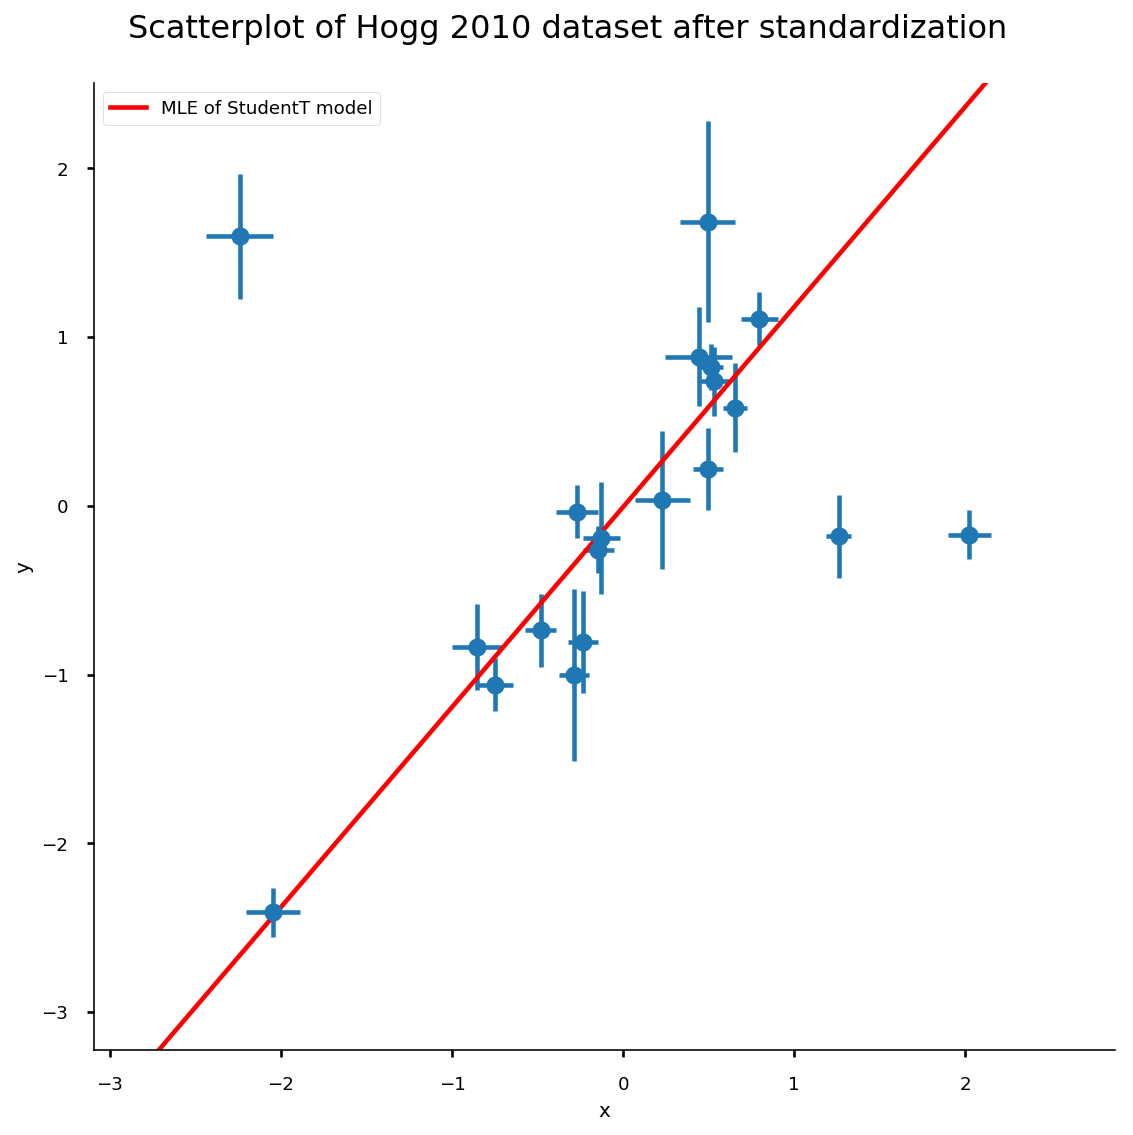

In [0]:
b0est, b1est, dfest = lbfgs_results.position.numpy()

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, 
                  color='r', label='MLE of StudentT model')
plt.legend();

#### MCMC

In [0]:
logp = lambda b0, b1, df: mdl_studentt.log_prob([b0, b1, df, Y_np])

@tf.function(autograph=False)
def run_chain(number_of_steps = 1000, burnin = 1000, nchain = 4):
  # random initialization of the starting postion of each chain
  b0, b1, df, _ = mdl_studentt.sample(nchain)

  # bijector to map contrained parameters to real
  unconstraining_bijectors = [
      tfb.Identity(),
      tfb.Identity(),
      tfp_interval,
  ]

  def trace_fn(_, pkr):
    return (pkr.inner_results.inner_results.is_accepted,
            pkr.inner_results.inner_results.accepted_results.step_size)

  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=logp,
      num_leapfrog_steps=3,
      step_size=[tf.cast(i, dtype=dtype) for i in [.1, .1, .02]]),
    bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    kernel,
    target_accept_prob=tf.cast(.8, dtype=dtype),
    # Adapt for the entirety of the burnin.
    num_adaptation_steps=burnin
    )

  # Sampling from the chain.
  mcmc_trace, (is_accepted, step_size) = tfp.mcmc.sample_chain(
      num_results = number_of_steps,
      num_burnin_steps = burnin,
      current_state=[b0, b1, tf.ones_like(df, dtype)*1.2],
      kernel=hmc,
      trace_fn=trace_fn)
  return mcmc_trace, is_accepted, step_size

# Sample from posterior distribution and get diagnostic
mcmc_trace, is_accepted, step_size = run_chain()
ess = tfp.mcmc.effective_sample_size(mcmc_trace)
rhat = tfp.mcmc.potential_scale_reduction(mcmc_trace)

In [0]:
print("acceptance rate: {}".format(is_accepted.numpy().mean()))
print("final 100 step size: {}".format(np.asarray(step_size[-100:]).mean(-1)))
print("The effective sample size is: ")
print(np.asarray(ess))
print("The rhat is: ")
print(np.asarray(rhat))

acceptance rate: 0.759
final 100 step size: [0.07875661 0.07875661 0.01575132]
The effective sample size is: 
[[1000.         1000.         1000.         1000.        ]
 [ 682.39666596 1000.         1000.         1000.        ]
 [   5.55298093    4.77904298    3.67218607   10.41560054]]
The rhat is: 
[1.00076018 1.00330769 1.51268799]


The samples for `df` is pretty horrible - we will need better tuning of HMC (e.g., NUTS).

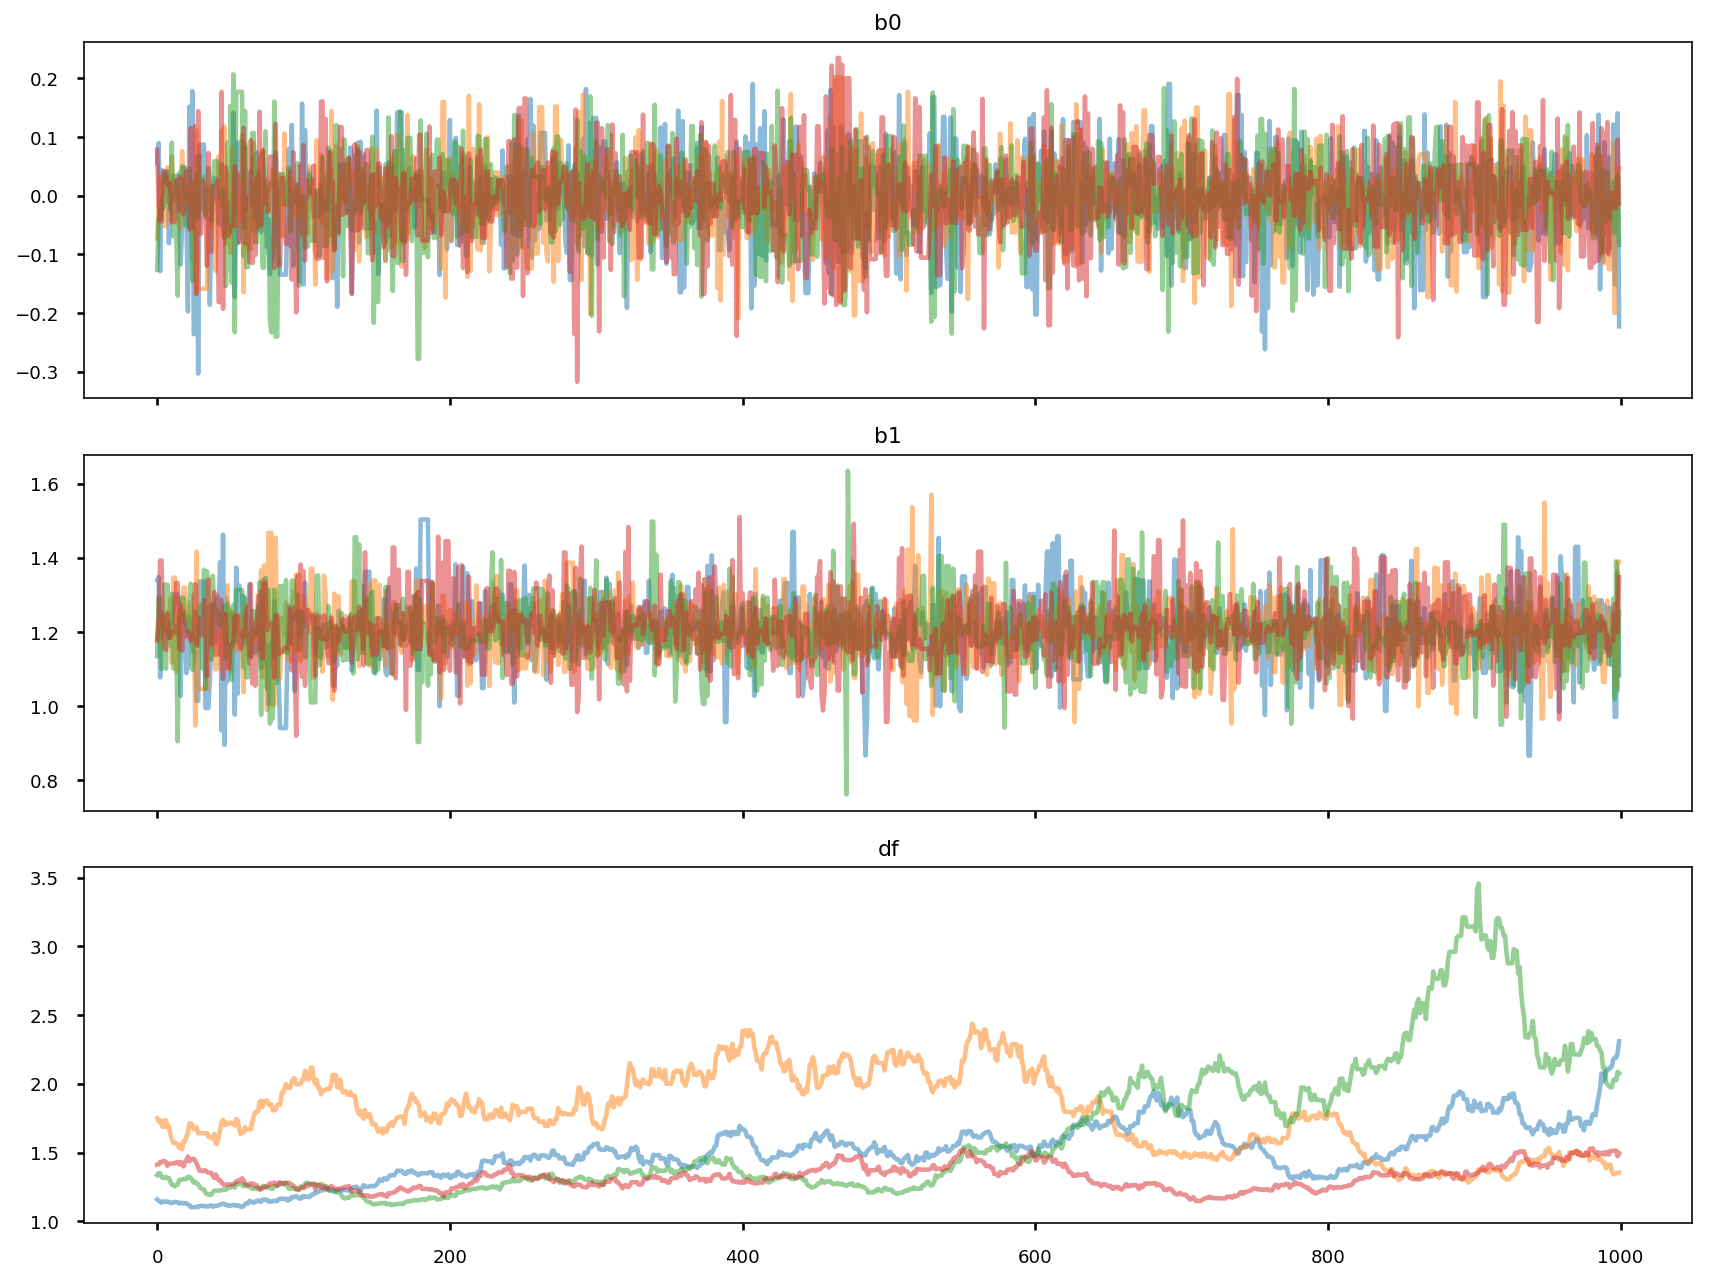

In [0]:
var_name = ['b0', 'b1', 'df']
n_var = len(mcmc_trace)
_, ax = plt.subplots(n_var, 1, figsize=(12, 3*n_var), sharex=True)
for i in range(n_var):
  ax[i].plot(mcmc_trace[i].numpy().squeeze(), alpha=.5)
  ax[i].set_title(var_name[i])
plt.tight_layout();

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


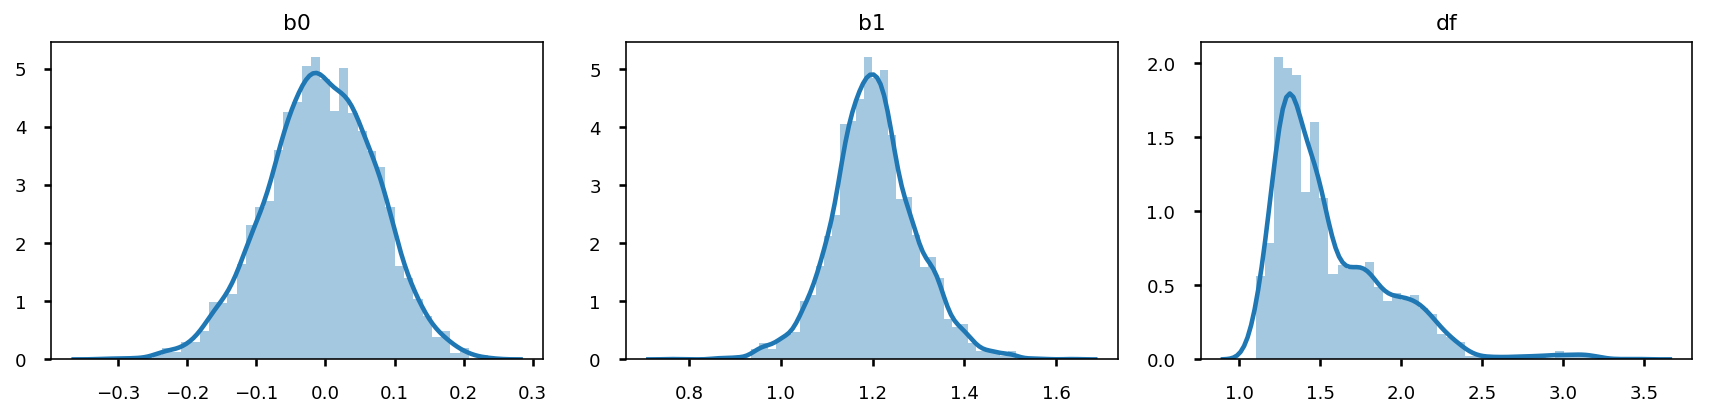

In [0]:
var_name = ['b0', 'b1', 'df']
n_var = len(mcmc_trace)
_, ax = plt.subplots(1, 3, figsize=(12, 3))
ax = ax.flatten()
for i in range(n_var):
  sns.distplot(mcmc_trace[i].numpy().flatten(), ax=ax[i])
  ax[i].set_title(var_name[i])
plt.tight_layout();

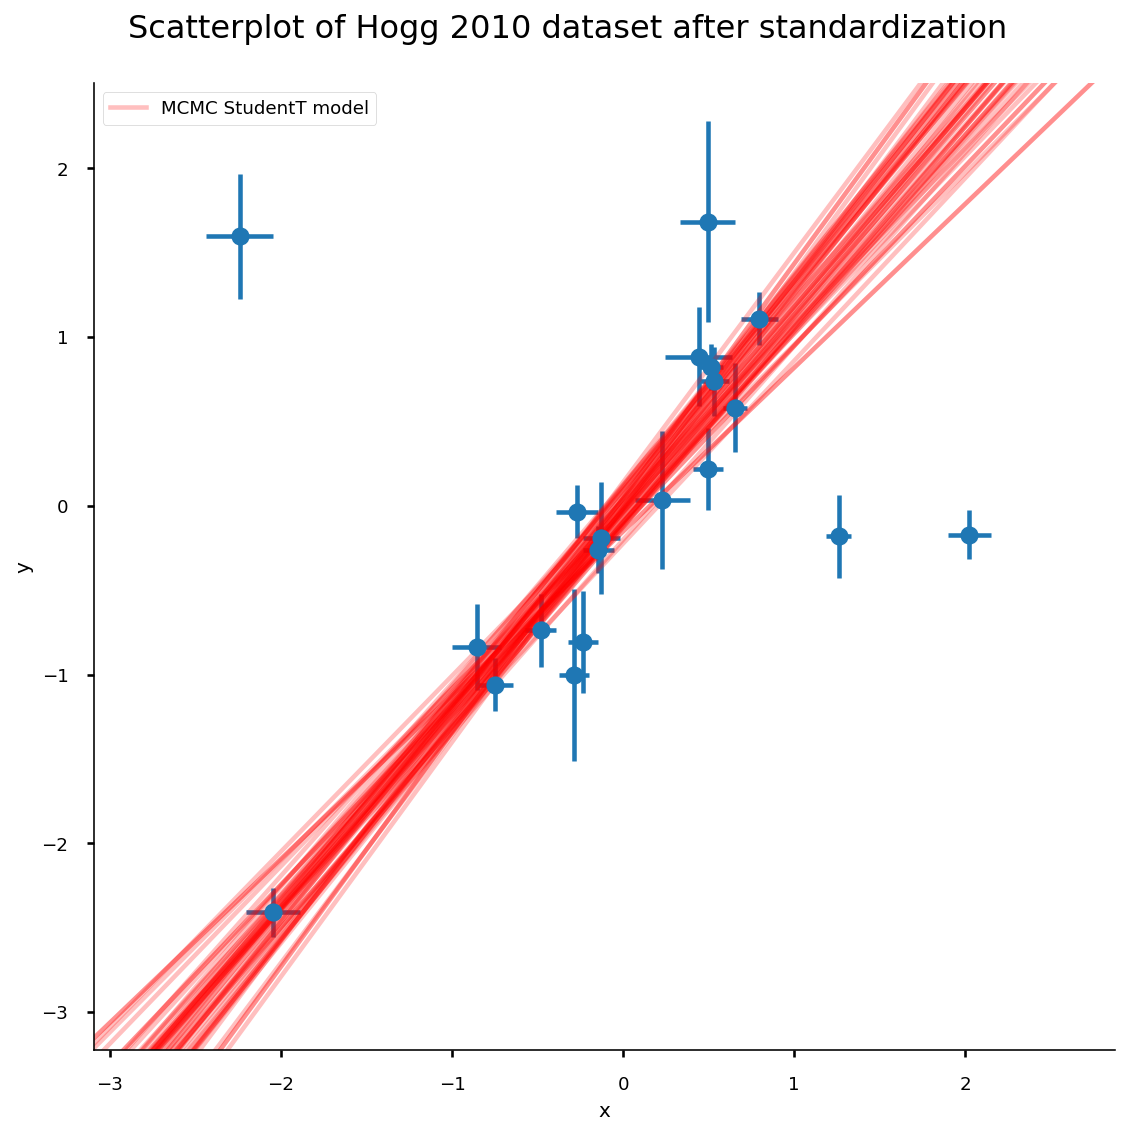

In [0]:
k = 50
b0est, b1est = mcmc_trace[0].numpy().flatten()[-k:, None], mcmc_trace[1].numpy().flatten()[-k:, None]

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)[None, :]
g.axes[0][0].plot(np.tile(xrange, (k, 1)).T,
                  (b0est + b1est*xrange).T,
                  alpha=.25, color='r')
plt.legend([g.axes[0][0].lines[-1]], ['MCMC StudentT model']);

## Hierarchical Partial Pooling

From PyMC3 [baseball data for 18 players from Efron and Morris (1975)](https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html#Hierarchical-Partial-Pooling)

In [0]:
data = pd.read_table('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/efron-morris-75-data.tsv',
                     sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T
n = len(at_bats)

In [0]:
a, b = tf.cast(0, dtype), tf.cast(1, dtype)
mdl_baseball = tfd.JointDistributionSequential([
    # phi
    tfd.Uniform(low=a, high=b),
    # kappa_log
    tfd.Exponential(rate=tf.cast(1.5, dtype)),
    # thetas
    lambda kappa_log, phi: tfd.Independent(
        tfd.Beta(
            concentration1=tf.tile((tf.exp(kappa_log)*phi)[:, None], (1, n)),
            concentration0=tf.tile((tf.exp(kappa_log)*(1.0-phi))[:, None], (1, n)))
    ),
    # likelihood
    lambda thetas: tfd.Independent(
        tfd.Binomial(
            total_count=tf.cast(at_bats, dtype),
            probs=thetas
        )), 
])

mdl_baseball._resolve_graph()

(('phi', ()),
 ('kappa_log', ()),
 ('thetas', ('kappa_log', 'phi')),
 ('x', ('thetas',)))

#### Forward sample (prior predictive sampling)

In [0]:
phi, kappa_log, thetas, y = mdl_baseball.sample(4)
phi, kappa_log, thetas, y

(<tf.Tensor: id=316449, shape=(4,), dtype=float64, numpy=array([0.11238472, 0.88661436, 0.84051893, 0.28129862])>,
 <tf.Tensor: id=316479, shape=(4,), dtype=float64, numpy=array([0.73524838, 0.14636048, 0.58078668, 0.26228354])>,
 <tf.Tensor: id=316535, shape=(4, 18), dtype=float64, numpy=
 array([[7.36849562e-01, 9.95201340e-03, 7.94408336e-02, 1.40155678e-01,
         2.43984877e-02, 1.67803082e-04, 7.50358314e-05, 1.41574610e-01,
         1.17251814e-06, 1.58951224e-02, 2.46475851e-02, 1.12306072e-01,
         7.94596644e-01, 2.55416343e-03, 6.19344561e-02, 1.91369527e-01,
         7.22684617e-03, 3.65472495e-01],
        [6.97556386e-01, 9.99999982e-01, 9.79726381e-01, 9.99984158e-01,
         9.99986383e-01, 4.31171135e-01, 9.70810398e-01, 1.00000000e+00,
         9.99967113e-01, 9.51271161e-01, 9.98092705e-01, 9.99838833e-01,
         9.76649577e-01, 9.72637501e-01, 9.99214848e-01, 9.94813354e-01,
         9.28027217e-01, 9.99985453e-01],
        [9.81920020e-01, 9.62062378e-01, 

Again, notice how if you dont use Independent you will end up with log_prob that has wrong batch_shape.

In [0]:
  # check logp
pprint(mdl_baseball.log_prob_parts([phi, kappa_log, thetas, hits]))
print(mdl_baseball.log_prob([phi, kappa_log, thetas, hits]))

(<tf.Tensor: id=316615, shape=(4,), dtype=float64, numpy=array([0., 0., 0., 0.])>,
 <tf.Tensor: id=316625, shape=(4,), dtype=float64, numpy=array([-0.69740746,  0.18592438, -0.46571491,  0.0120398 ])>,
 <tf.Tensor: id=316642, shape=(4,), dtype=float64, numpy=array([29.9681446 , 79.86482637, 22.74993342,  9.26565136])>,
 <tf.Tensor: id=316661, shape=(4,), dtype=float64, numpy=array([ -594.55635711, -3999.64989381, -1671.93438249,  -424.91945076])>)
tf.Tensor([ -565.28561997 -3919.59914306 -1649.65016399  -415.64175959], shape=(4,), dtype=float64)


### MLE

In [0]:
phi, kappa_log, thetas, y = mdl_baseball.sample()

x = tf.concat([phi, kappa_log, tf.squeeze(thetas)], 0)
# [[x[0]], [x[1]], [x[2:]], hits]

mdl_baseball.log_prob([[x[0]], [x[1]], [x[2:]], hits])

<tf.Tensor: id=317011, shape=(1,), dtype=float64, numpy=array([-912.02262238])>

In [0]:
tfp_sigmoid = tfb.Sigmoid()
tfp_exp = tfb.Exp()


neg_log_p = lambda x: -tf.reduce_sum(
        mdl_baseball.log_prob([
            [tfp_sigmoid.forward(x[0])], 
            [tfp_exp.forward(x[1])],
            [tfp_sigmoid.forward(x[2:])], 
            hits])
    )

def neg_log_likelihood(x):
  return tfp.math.value_and_gradient(neg_log_p, x)


start = tf.concat([
    tfp_sigmoid.inverse(phi), 
    tfp_exp.inverse(kappa_log), 
    tfp_sigmoid.inverse(tf.squeeze(thetas))
], 0)

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    num_correction_pairs=10,
    initial_position=start,
    tolerance=1e-50,
    x_tolerance=1e-20,
    max_iterations=200
)

In [0]:
lbfgs_results.converged.numpy(), lbfgs_results.failed.numpy()

(False, True)

LBFGS did not converged.

In [0]:
map_param = lambda x: [
            [tfp_sigmoid.forward(x[0]).numpy()], 
            [tf.exp(tfp_exp.forward(x[1])).numpy()], 
            [tfp_sigmoid.forward(x[2:]).numpy()]
]

phi_est, kappa_est, theta_est = map_param(lbfgs_results.position)
phi_est, kappa_est, theta_est

([0.29293730411002206],
 [8.617866648389107],
 [array([0.45451533, 0.2510944 , 0.32166945, 0.387547  , 0.37580962,
         0.32793856, 0.35841001, 0.2579077 , 0.28491306, 0.24492304,
         0.21874933, 0.21192105, 0.16833819, 0.14813553, 0.23497588,
         0.17677938, 0.168865  , 0.27363491])])

### MCMC

In [0]:
logp = lambda phi, kappa_log, thetas: mdl_baseball.log_prob([phi, kappa_log, thetas, hits])

@tf.function(autograph=False)
def run_chain(number_of_steps = 1000, burnin = 5000, nchain = 4):
  # random initialization of the starting postion of each chain
  phi, kappa_log, thetas, _ = mdl_baseball.sample(nchain, n)

  unconstraining_bijectors = [
      tfp_sigmoid,
      tfp_exp,
      tfp_sigmoid,
  ]

  def trace_fn(_, pkr):
    return (pkr.inner_results.inner_results.is_accepted,
            pkr.inner_results.inner_results.accepted_results.step_size)

  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=logp,
      num_leapfrog_steps=3,
      step_size=[tf.cast(i, dtype=dtype) for i in [.1, .1, .1]]),
    bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    kernel,
    target_accept_prob=tf.cast(.8, dtype=dtype),
    # Adapt for the entirety of the trajectory.
    num_adaptation_steps=burnin
    )

  # Sampling from the chain.
  mcmc_trace, (is_accepted, step_size) = tfp.mcmc.sample_chain(
      num_results = number_of_steps,
      num_burnin_steps = burnin,
      current_state=[phi, tf.ones_like(kappa_log, dtype=dtype), thetas],
      kernel=hmc,
      trace_fn=trace_fn)
  return mcmc_trace, is_accepted, step_size

# Sample from posterior distribution and get diagnostic
mcmc_trace, is_accepted, step_size = run_chain()
ess = tfp.mcmc.effective_sample_size(mcmc_trace)
rhat = tfp.mcmc.potential_scale_reduction(mcmc_trace)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:498: UserWarning: `step_size` is not a `tf.Tensor`, Python number of Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))


In [0]:
print("acceptance rate: {}".format(is_accepted.numpy().mean()))
print("final 100 step size: {}".format(np.asarray(step_size[-100:]).mean(-1)))
print("The effective sample size is: ")
print([es.numpy() for es in ess])
print("The rhat is: ")
print([r.numpy() for r in rhat])

acceptance rate: 0.73325
final 100 step size: [0.0698925 0.0698925 0.0698925]
The effective sample size is: 
[array([ 79.27253018,  89.66246252, 113.23732483,  55.23144819]), array([17.33101982, 57.71415327, 31.14981691, 91.32618809]), array([[ 30.69446582,  46.74324518, 111.18310866, 196.87969211,
        171.97459745, 136.58498287, 240.15800947, 177.3397248 ,
        147.15905751, 133.87936064, 157.0492998 , 105.90113466,
         91.58652486, 185.98005198, 133.8984494 , 173.87188494,
        120.27473426, 111.13511004],
       [151.75329584, 119.06784708, 154.3518628 , 145.55101924,
        137.69832582, 127.60893147, 186.73529691,  74.64915649,
        141.26494983, 156.13179347, 111.16418871,  91.70470575,
        151.89722803, 202.72906973, 114.04152106, 118.58246678,
        121.35794121,  90.10622556],
       [ 80.79336519, 134.03667268, 196.47940424, 132.61590791,
        144.00044558, 152.14372367, 160.71705057, 148.68110269,
        100.86990834, 150.15040485, 175.09931385, 

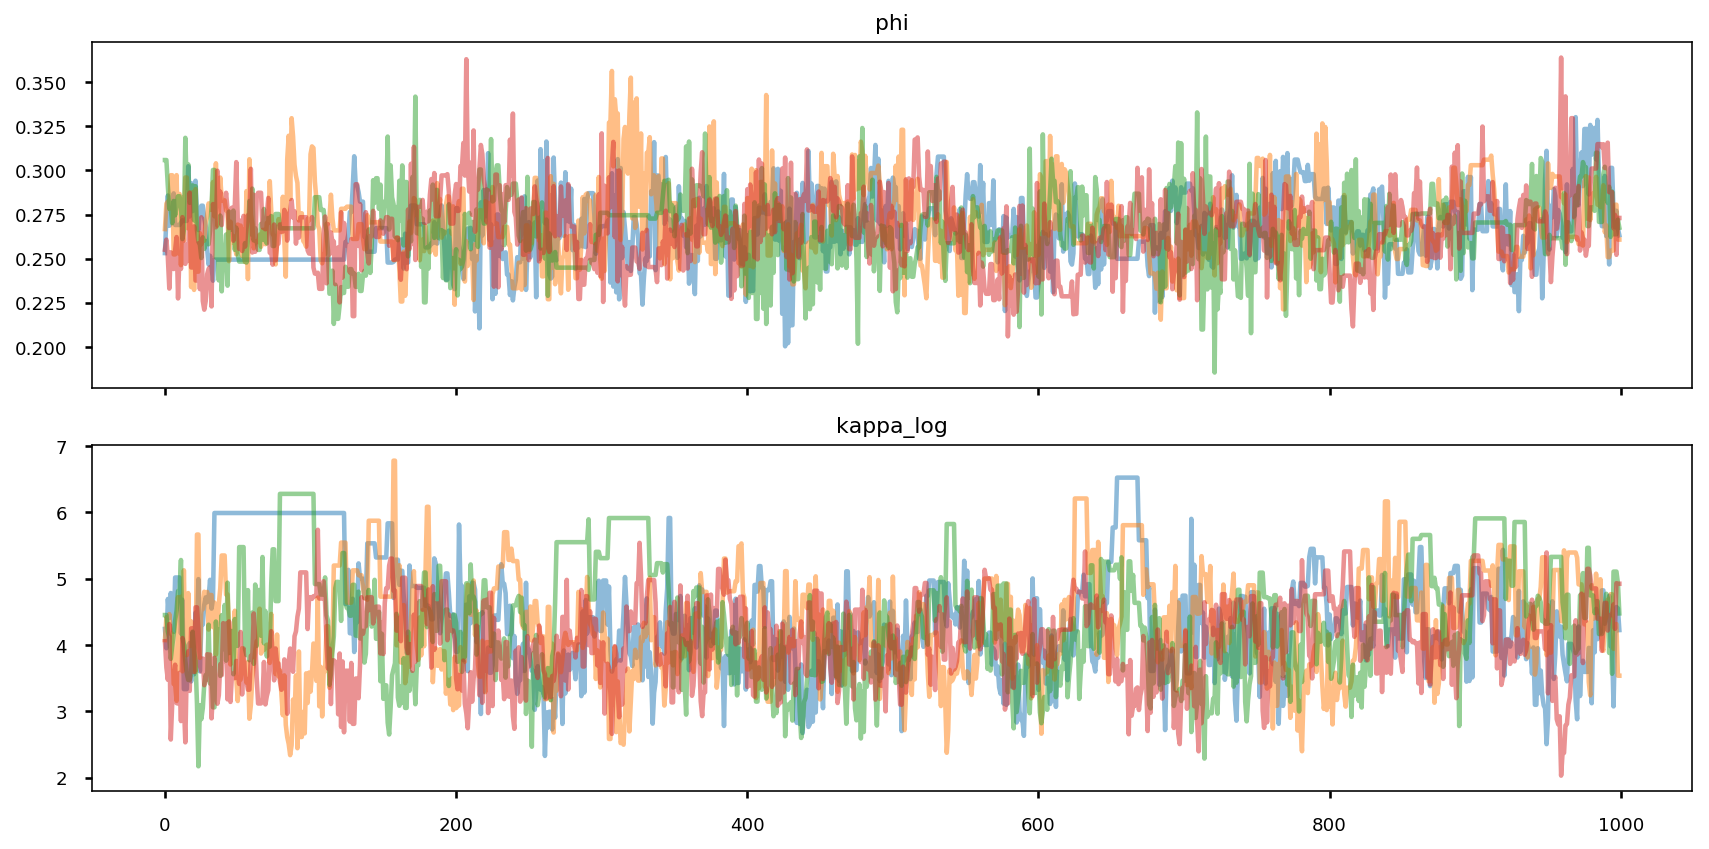

In [0]:
var_name = ['phi', 'kappa_log']
n_var = len(var_name)
_, ax = plt.subplots(n_var, 1, figsize=(12, 3*n_var), sharex=True)
for i in range(n_var):
  ax[i].plot(mcmc_trace[i].numpy().squeeze(), alpha=.5)
  ax[i].set_title(var_name[i])
plt.tight_layout();

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


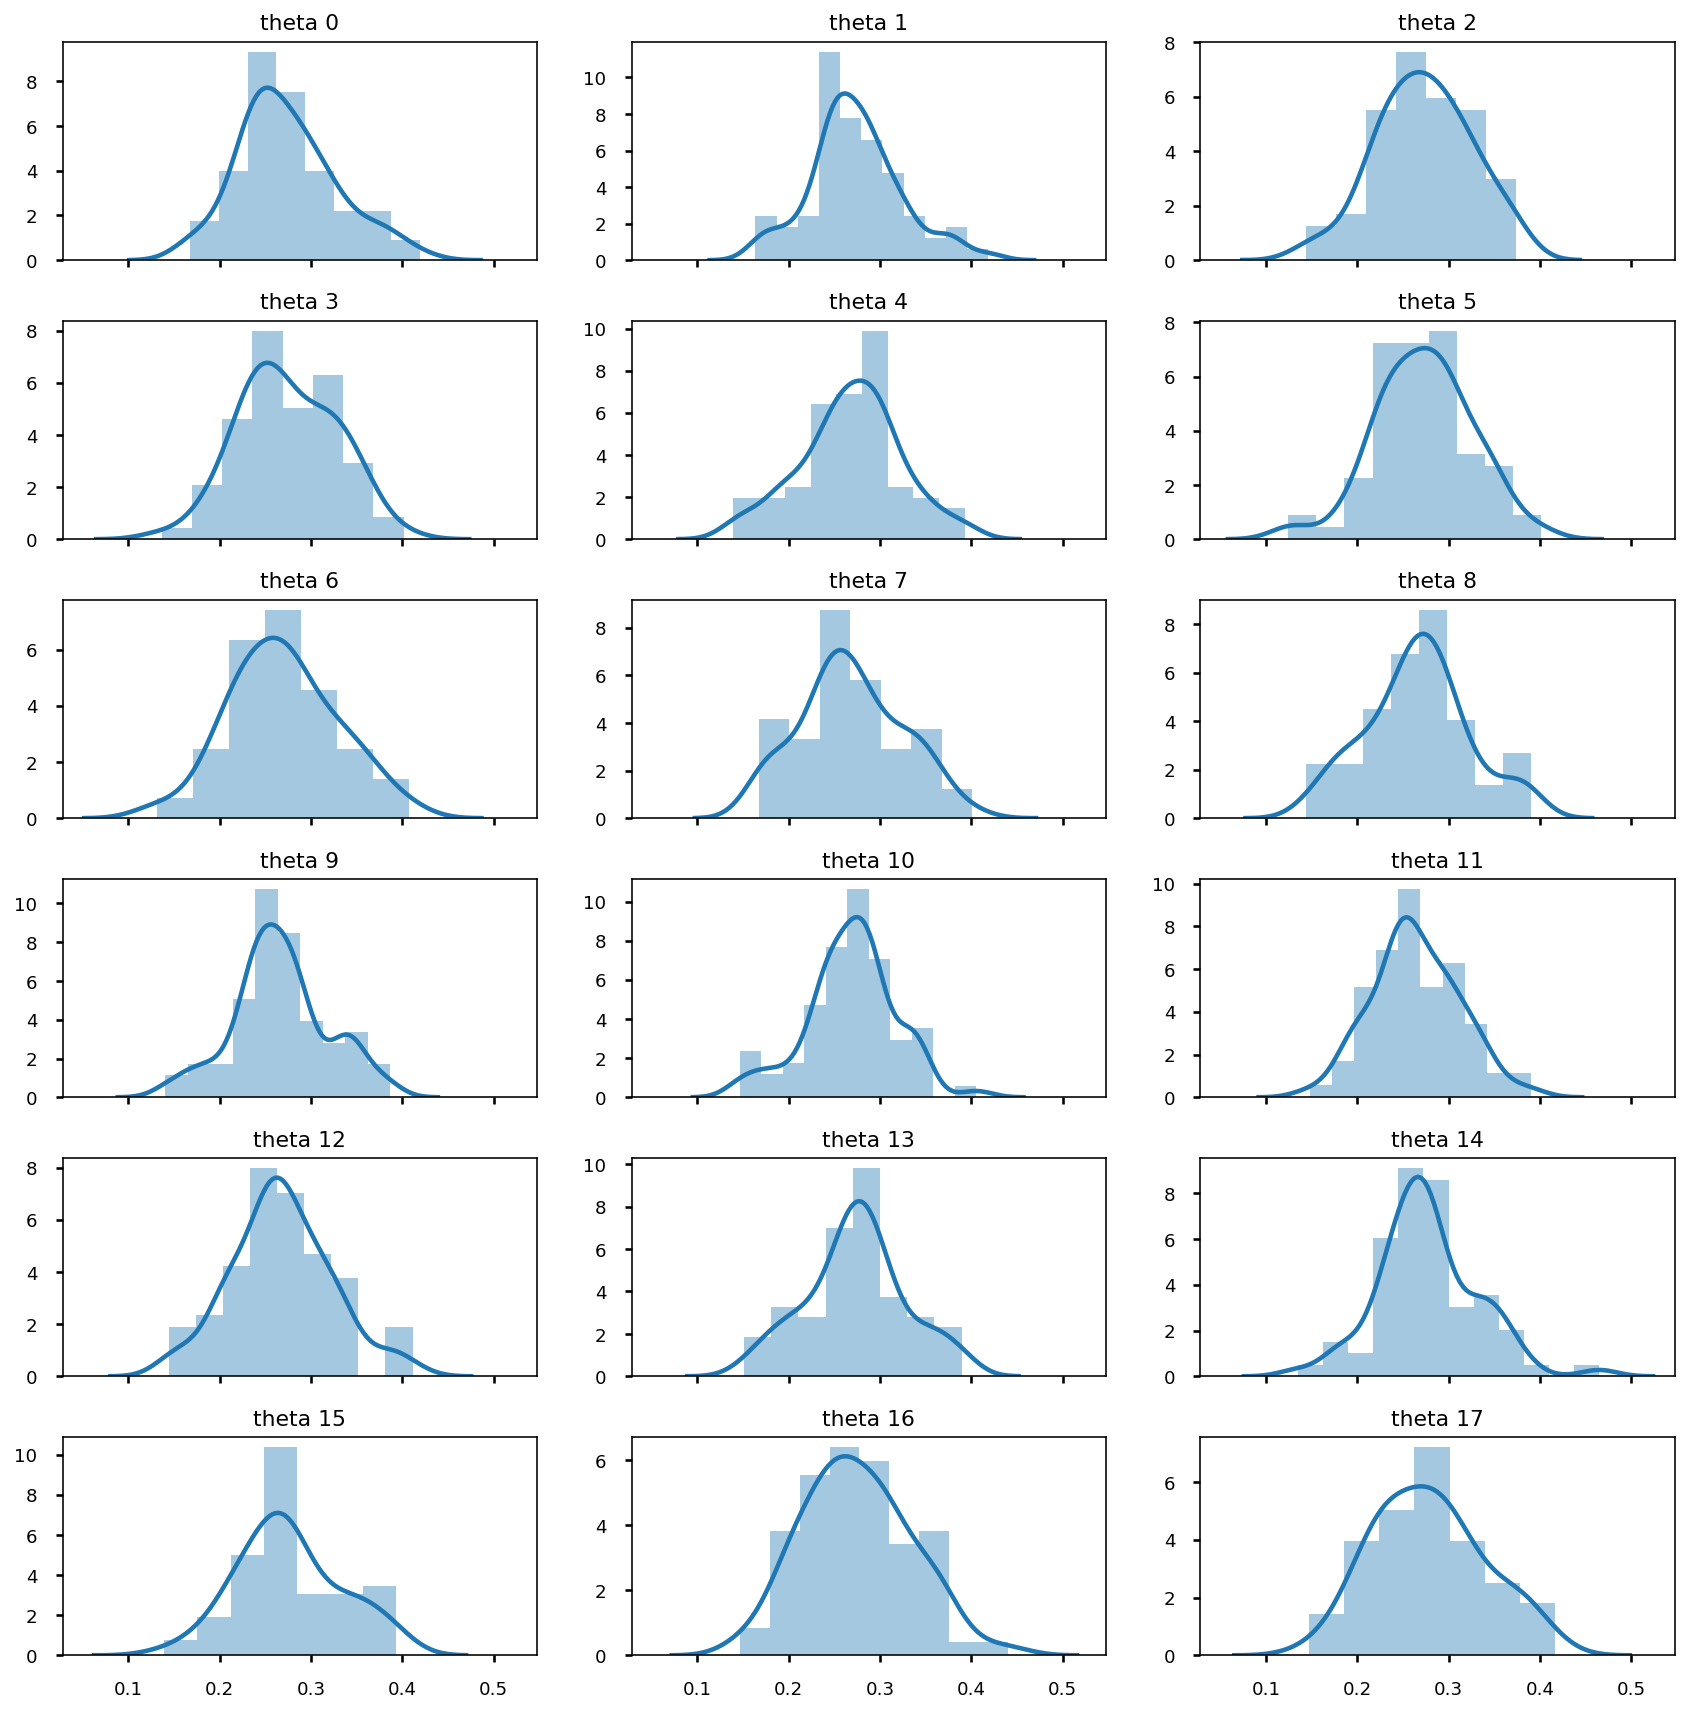

In [0]:
_, ax = plt.subplots(6, 3, figsize=(12, 12), sharex=True)
ax = ax.flatten()
for i in range(n):
  sns.distplot(mcmc_trace[-1][i].numpy().flatten(), ax=ax[i])
  ax[i].set_title('theta %s'%i)
plt.tight_layout();

## Mixed effect model
The last model in the PyMC3 doc: [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/notebooks/multilevel_modeling.html)

Some changes in prior (smaller scale etc)

In [0]:
srrs2 = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/srrs2.dat')

srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips

cty = pd.read_csv('https://raw.githubusercontent.com/pymc-devs/pymc3/master/pymc3/examples/data/cty.dat')
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values.astype('float')

# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

Batch version of a mixed effect model. It need some gymnastics to make sure the function is behave as intended.

In [0]:
mu0 = tf.zeros([], dtype, name='mu0') # hyperprior
contextual_effect2 = tfd.JointDistributionSequential([
    # sigma_a
    tfd.HalfCauchy(loc=mu0, scale=5.),
    # gamma
    tfd.Sample(tfd.Normal(loc=mu0, scale=100.), 3),
    # eps_a
    lambda gamma, sigma_a: tfd.Sample(
        tfd.Normal(loc=mu0, scale=sigma_a), counties),
    # b
    tfd.Normal(loc=mu0, scale=100.),
    # sigma_y
    tfd.HalfCauchy(loc=mu0, scale=5.),
    # likelihood
    lambda sigma_y, b, eps_a, gamma, sigma_a: tfd.Independent(
        tfd.Normal(
            # parameter transformation (linear equation), this is a long one
            loc=(tf.transpose((gamma[..., 0]
                             + gamma[..., 1]*u.values[:, None]
                             + gamma[..., 2]*xbar[county][:, None]))
                 + tf.gather(eps_a, county, axis=1)
                 + b[..., None]*floor_measure),
            scale=sigma_y[:, None]
        ),
        reinterpreted_batch_ndims=1
    ),
])

contextual_effect2._resolve_graph()

(('sigma_a', ()),
 ('gamma', ()),
 ('eps_a', ('gamma', 'sigma_a')),
 ('b', ()),
 ('sigma_y', ()),
 ('x', ('sigma_y', 'b', 'eps_a', 'gamma', 'sigma_a')))

For models with complex transformation, implementing it in a functional style would make writing and testing much easier. Also, it makes programmtically generate log_prob function that conditioned on (mini-batch) of inputted data much easier:



In [0]:
@tf.function(autograph=False)
def affine(u_val, x_county, county, floor, gamma, eps, b):
  """Linear equation of the coefficients and the covariates, with broadcasting."""
  return (tf.transpose((gamma[..., 0]
                      + gamma[..., 1]*u_val[:, None]
                      + gamma[..., 2]*x_county[:, None]))
          + tf.gather(eps, county, axis=1)
          + b[..., None]*floor)


mu0 = tf.zeros([], dtype, name='mu0') # hyperprior
def model(u_val, x_county, county, floor):
  """Creates a joint distribution representing our generative process."""
  return tfd.JointDistributionSequential([
      # sigma_a
      tfd.HalfCauchy(loc=mu0, scale=5.),
      # gamma
      tfd.Sample(tfd.Normal(loc=mu0, scale=100.), 3),
      # eps
      lambda gamma, sigma_a: tfd.Sample(
          tfd.Normal(loc=mu0, scale=sigma_a), counties),
      # b
      tfd.Normal(loc=mu0, scale=100.),
      # sigma_y
      tfd.HalfCauchy(loc=mu0, scale=5.),
      # likelihood
      lambda sigma_y, b, eps, gamma, sigma_a: tfd.Independent(
          tfd.Normal(
              loc=affine(u_val, x_county, county, floor, gamma, eps, b),
              scale=sigma_y[:, None]
          ),
          reinterpreted_batch_ndims=1
      ),
  ])

@tf.function(autograph=False)
def unnormalized_posterior_log_prob(sigma_a, gamma, eps, b, sigma_y):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return model(u.values,  xbar[county], county, floor_measure).log_prob(
      [sigma_a, gamma, eps, b, sigma_y, log_radon])

assert [4] == unnormalized_posterior_log_prob(
    *contextual_effect2.sample(4)[:-1]).shape

In [0]:
samples = contextual_effect2.sample(4)
pprint([s.shape for s in samples])

[TensorShape([4]),
 TensorShape([4, 3]),
 TensorShape([4, 85]),
 TensorShape([4]),
 TensorShape([4]),
 TensorShape([4, 919])]


In [0]:
contextual_effect2.log_prob_parts(list(samples)[:-1] + [log_radon])

(<tf.Tensor: id=342, shape=(4,), dtype=float64, numpy=array([-5.41844047, -3.87152011, -2.84174452, -2.10789952])>,
 <tf.Tensor: id=353, shape=(4,), dtype=float64, numpy=array([-17.56332462, -17.03142865, -17.30196514, -17.05319805])>,
 <tf.Tensor: id=364, shape=(4,), dtype=float64, numpy=array([-399.54830409, -326.31849781, -267.62741759, -136.70364344])>,
 <tf.Tensor: id=373, shape=(4,), dtype=float64, numpy=array([-5.5313702 , -6.39788534, -6.39827407, -5.92963928])>,
 <tf.Tensor: id=400, shape=(4,), dtype=float64, numpy=array([-2.09746099, -2.3345616 , -2.07782896, -2.25762463])>,
 <tf.Tensor: id=411, shape=(4,), dtype=float64, numpy=
 array([-1624788.7349571 ,  -442158.19642185, -4995286.55750218,
         -270878.94377691])>)

### Variational Inference

One very powerful feature of `JointDistribution` is that you can generate an approximation easily for VI. For example, to do meanfield ADVI, you simply inspect the graph and replace all the none observed distribution with a Normal distribution.

In [0]:
from tensorflow_probability.python.mcmc.transformed_kernel import forward_log_det_jacobian_fn
from tensorflow_probability.python.mcmc.transformed_kernel import forward_transform_fn
from tensorflow_probability.python.mcmc.transformed_kernel import inverse_transform_fn

In [0]:
hparams = dict(
    init_raw_scale=np.log(np.expm1(1.)),  # approx= 0.5413
    scale_diag_offset=1e-3,
    
    num_monte_carlo_draws=10,

    train_iterations = int(1e4),

    learning_rate_start = 1e-2,
    learning_rate_num_epochs_per_decay = 10,
    learning_rate_decay_factor = 0.99,
)

In [0]:
# wrap logp so that all parameters are in R
# copied from tensorflow_probability/python/mcmc/transformed_kernel.py
unconstraining_bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

_forward_transform = forward_transform_fn(unconstraining_bijectors)
_forward_log_det_jacobian = forward_log_det_jacobian_fn(unconstraining_bijectors)
_inverse_transform = inverse_transform_fn(unconstraining_bijectors)

unnormalized_log_prob = lambda input_list: contextual_effect2.log_prob(
    list(input_list) + [log_radon])

def contextual_effect_posterior(transformed_state_parts):
  """Log prob of the transformed state."""
  # TODO(b/72831017): Use `tf.identity` to disable caching (since HMC takes
  # gradient with respect to input).
  transformed_state_parts = [
      tf.identity(sp) for sp in transformed_state_parts
  ]
  tlp = unnormalized_log_prob(
      _forward_transform(transformed_state_parts))
  event_ndims = [
      tf.rank(sp) - tf.rank(tlp) for sp in transformed_state_parts
  ]
  return tlp + _forward_log_det_jacobian(
      transformed_state_parts=transformed_state_parts,
      event_ndims=event_ndims)

# Check the two versions of log_prob - they should be different given the Jacobian
rv_samples = contextual_effect2.sample(4)

pprint([
    unnormalized_log_prob(rv_samples[:-1]),
    contextual_effect_posterior(_inverse_transform(rv_samples[:-1])),
    unnormalized_log_prob(
        _forward_transform(
            tf.zeros_like(a, dtype=dtype) for a in rv_samples[:-1])
    ),
    contextual_effect_posterior(
        [tf.zeros_like(a, dtype=dtype) for a in rv_samples[:-1]]
    ),
])

[<tf.Tensor: id=820, shape=(4,), dtype=float64, numpy=
array([-9473372.27189421,   -41824.77491201, -4183341.86334486,
         -49287.26914885])>,
 <tf.Tensor: id=1100, shape=(4,), dtype=float64, numpy=
array([-9473371.1465941 ,   -41819.51269083, -4183341.99436029,
         -49284.10382767])>,
 <tf.Tensor: id=1263, shape=(4,), dtype=float64, numpy=array([-1992.10420767, -1992.10420767, -1992.10420767, -1992.10420767])>,
 <tf.Tensor: id=1540, shape=(4,), dtype=float64, numpy=array([-1992.10420767, -1992.10420767, -1992.10420767, -1992.10420767])>]


#### Meanfield ADVI

In [0]:
# Build meanfield ADVI for a jointdistribution
# Inspect the input jointdistribution and replace the list of distribution with
# a list of Normal distribution, each with the same shape.
def gen_params_meanfield(jd, observed_node=-1):
  """
  The inputted jointdistribution needs to be a batch version
  """
  # sample to get a list of samples
  list_of_values = list(jd.sample())
  
  # remove the observed node
  list_of_values.pop(observed_node)
  
  # iterate sample to a build a list of parameters for Normal
  free_param = []
  for i, value in enumerate(list_of_values):
    dtype = value.dtype
    rv_shape = value[0].shape
    loc = tf.Variable(
        tf.random.normal(rv_shape, dtype=dtype),
        name='meanfield_%s_mu' % i,
        dtype=dtype)
    rho = tf.Variable(
        tf.random.normal(rv_shape, dtype=dtype),
        name='meanfield_%s_rho' % i,
        dtype=dtype)
    free_param.append([loc, rho])
  return free_param

def build_meanfield_advi(param):
  distlist = []
  for loc, rho in param:
    approx_node = tfd.Normal(loc=loc, scale=tf.nn.softplus(rho))
    if loc.shape == ():
      distlist.append(approx_node)
    else:
      distlist.append(
          # TODO: make the reinterpreted_batch_ndims more flexible (for 
          # minibatch etc)
          tfd.Independent(approx_node, reinterpreted_batch_ndims=1)
      )

  # pass list to JointDistribution to initiate the meanfield advi
  meanfield_advi = tfd.JointDistributionSequential(distlist)
  return meanfield_advi

In [0]:
free_param = gen_params_meanfield(contextual_effect2, observed_node=-1)
advi = build_meanfield_advi(free_param)


# Check the logp and logq
advi_samples = advi.sample(4)
contextual_effect_posterior(advi_samples)

<tf.Tensor: id=2381, shape=(4,), dtype=float64, numpy=
array([  -3328.53203431, -133035.42453058,   -3940.0168169 ,
        -30161.31746941])>

In [0]:
advi.reparameterization_type

(<Reparameteriation Type: FULLY_REPARAMETERIZED>,
 <Reparameteriation Type: FULLY_REPARAMETERIZED>,
 <Reparameteriation Type: FULLY_REPARAMETERIZED>,
 <Reparameteriation Type: FULLY_REPARAMETERIZED>,
 <Reparameteriation Type: FULLY_REPARAMETERIZED>)

In [0]:
def elbo_loss():
  advi = build_meanfield_advi(free_param)
  return tfp.vi.monte_carlo_csiszar_f_divergence(
    f=tfp.vi.kl_reverse,  # same as: Evidence Lower BOund
    p_log_prob=contextual_effect_posterior,
    q=advi,
    num_draws=hparams['num_monte_carlo_draws'],
    name='elbo_loss')
print(elbo_loss)

learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hparams['learning_rate_start'],
    decay_steps=hparams['learning_rate_num_epochs_per_decay'],
    decay_rate=hparams['learning_rate_decay_factor'],
    staircase=True)

opt = tf.optimizers.Adam(learning_rate=learning_rate)

In [0]:
loss_ = np.zeros(hparams['train_iterations'])

@tf.function(autograph=False)
def train():
  opt.minimize(elbo_loss, var_list=free_param)
  return elbo_loss()

for iter_ in range(hparams['train_iterations']):
  loss_[iter_] = train()
  if iter_ % 1000 == 0 or iter_ == hparams['train_iterations'] - 1:
    print("iter:{:>4}  loss:{:.3f}".format(iter_, loss_[iter_]))

iter:   0  loss:2463.826
iter:1000  loss:1165.250
iter:2000  loss:1160.535
iter:3000  loss:1133.009
iter:4000  loss:1125.947
iter:5000  loss:1092.310
iter:6000  loss:1095.286
iter:7000  loss:1089.535
iter:8000  loss:1091.686
iter:9000  loss:1141.635
iter:9999  loss:1090.226


Note: the above is sensitive to initialization - simply reexcute the cell if the result does not look converged!

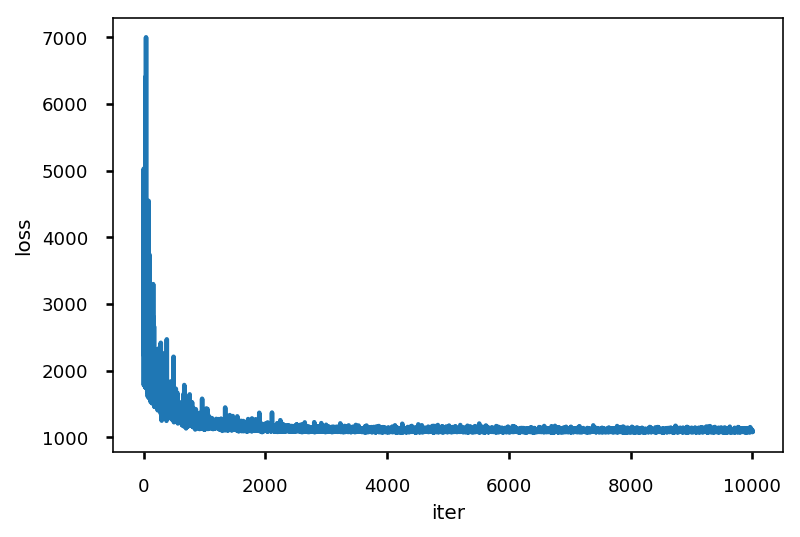

In [0]:
plt.plot(loss_);
plt.xlabel('iter');
plt.ylabel('loss');

In [0]:
graph_info = contextual_effect2._resolve_graph()
approx_param = dict()
for i, (rvname, param) in enumerate(graph_info[:-1]):
  approx_param[rvname] = {"mu": free_param[i][0].numpy(),
                          "sd": tf.nn.softplus(free_param[i][1]).numpy()}

In [0]:
approx_param.keys()

dict_keys(['sigma_a', 'gamma', 'eps_a', 'b', 'sigma_y'])

In [0]:
approx_param['gamma']

{'mu': array([1.43318606, 0.68470326, 0.37897743]),
 'sd': array([0.02515671, 0.07396542, 0.11222474])}

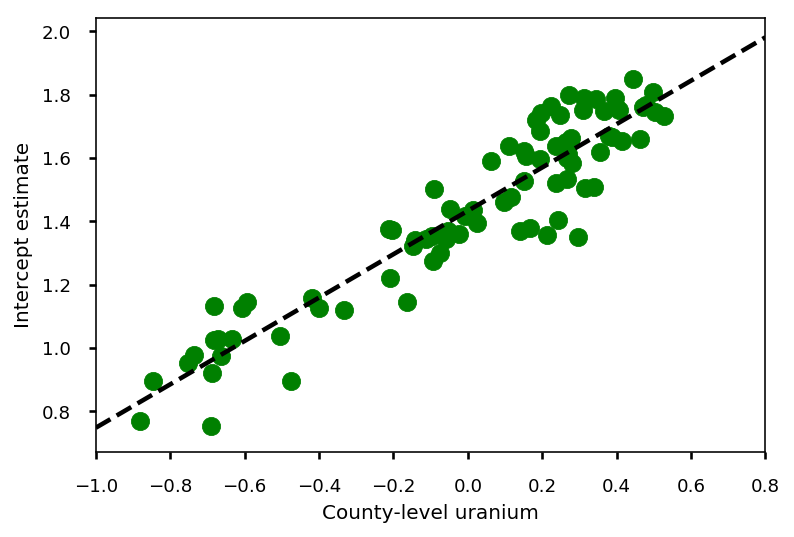

In [0]:
a_means = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
#          + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps_a']['mu'][county])
_, index = np.unique(county, return_index=True)
plt.scatter(u.values[index], a_means[index], color='g')

xvals = np.linspace(-1, 0.8)
plt.plot(xvals, 
         approx_param['gamma']['mu'][0]+approx_param['gamma']['mu'][1]*xvals, 
         'k--')
plt.xlim(-1, 0.8)

plt.xlabel('County-level uranium');
plt.ylabel('Intercept estimate');

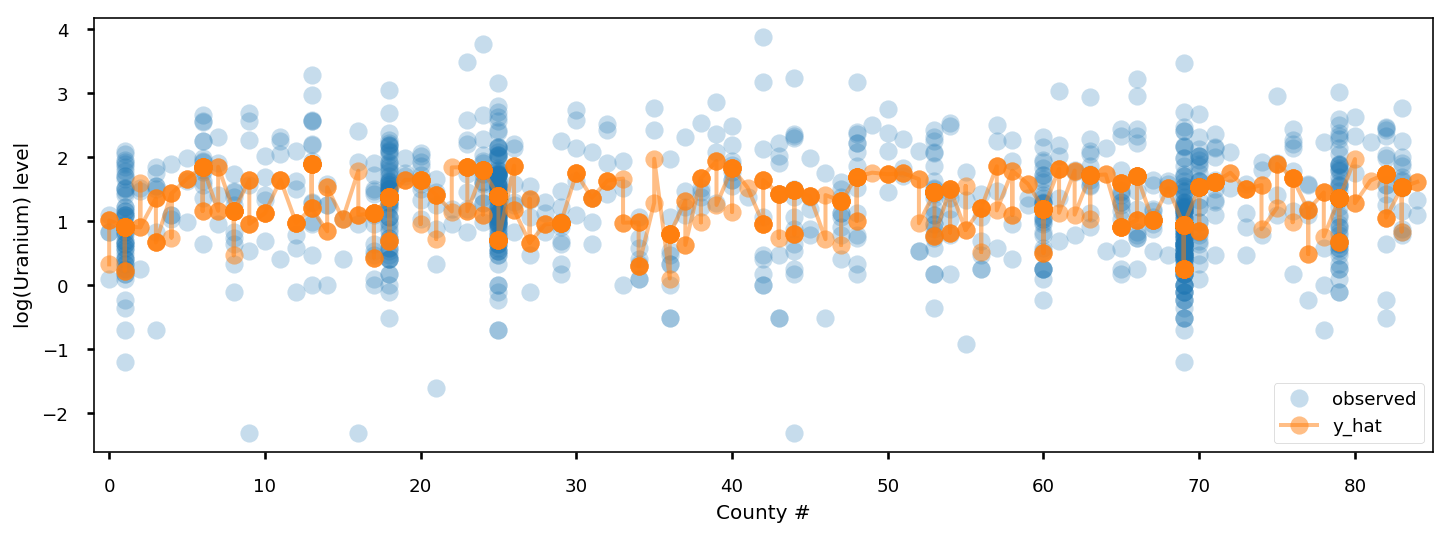

In [0]:
y_est = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps_a']['mu'][county]
         + approx_param['b']['mu']*floor_measure)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(county, log_radon, 'o', alpha=.25, label='observed')
ax.plot(county, y_est, '-o', lw=2, alpha=.5, label='y_hat')
ax.set_xlim(-1, county.max()+1)
plt.legend(loc='lower right')
ax.set_xlabel('County #')
ax.set_ylabel('log(Uranium) level');

#### (Structured) FullRank ADVI

In [0]:
def gen_params_fullrank(jd, observed_node=-1, rank='full'):
  # sample to get a list of samples
  list_of_values = list(jd.sample())
  
  # remove the observed node
  list_of_values.pop(observed_node)
  
  # iterate sample to a build a list of parameters for Normal or MvNormal
  free_param = []
  for i, value in enumerate(list_of_values):
    dtype = value.dtype
    rv_shape = value[0].shape
    if rv_shape == (): # scalar case
      loc=tf.Variable(
          tf.random.normal(rv_shape, dtype=dtype),
          name='lowrank_%s_mu' % i,
          dtype=dtype)
      rho = tf.Variable(
          tf.zeros(rv_shape, dtype=dtype),
          name='lowrank_%s_rho' % i,
          dtype=dtype)
      free_param.append([loc, rho])
    else: # None scalar RVs
      ndim = np.prod(rv_shape.as_list())
      loc = tf.Variable(
          tf.random.normal([ndim], dtype=dtype),
          name='lowrank_%s_mu' % i,
          dtype=dtype)
      
      if rank == 'full': # full rank
        raw_scale_tril = tf.Variable(
          tf.zeros([ndim * (ndim + 1) // 2], dtype=dtype),
          name='lowrank_%s_tril' % i,
          dtype=dtype)
        free_param.append([loc, raw_scale_tril])
      else: # low rank
        rank = 1
        raw_scale = tf.Variable(
          tf.zeros([ndim * (1 + rank)], dtype=dtype),
          name='lowrank_%s_scale' % i,
          dtype=dtype)
        free_param.append([loc, raw_scale])
  
  return free_param

def build_structure_advi(param, rank='full'):
  distlist = []
  for loc, cov_info in param:
    if loc.shape == ():
      approx_node = tfd.Normal(loc=loc, scale=tf.nn.softplus(cov_info))
    else:
      if rank == 'full': # full rank
        scale_tril = tfd.fill_triangular(cov_info)
        new_diag = hparams['scale_diag_offset'] + tf.nn.softplus(
          hparams['init_raw_scale'] + tf.diag_part(scale_tril))
        scale_tril = tf.linalg.set_diag(scale_tril, new_diag)
        approx_node = tfd.MultivariateNormalTriL(
          loc=loc,
          scale_tril=scale_tril)
      else: # low rank
        lower_rank = 1
        ndim = tf.shape(loc)[0]
        approx_node = tfd.MultivariateNormalDiagPlusLowRank(
          loc=loc,
          scale_diag=tf.nn.softplus(hparams['init_raw_scale'] + cov_info[:ndim]),
          scale_perturb_factor=tf.reshape(cov_info[ndim:], [ndim, lower_rank]))
    distlist.append(approx_node)
    
  # pass list to JointDistribution to initiate the fullrank advi
  structure_advi = tfd.JointDistributionSequential(distlist)
  return structure_advi

In [0]:
free_param = gen_params_fullrank(contextual_effect2, observed_node=-1, rank='low')
lowrank_advi = build_structure_advi(free_param, rank='low')


# Check the logp and logq
advi_samples = lowrank_advi.sample(4)
contextual_effect_posterior(advi_samples)

<tf.Tensor: id=9834865, shape=(4,), dtype=float64, numpy=array([-2246.52497888, -2168.70966642, -2657.63189247, -2843.68641044])>

In [0]:
def elbo_loss():
  lowrank_advi = build_structure_advi(free_param, rank='low')
  return tfp.vi.monte_carlo_csiszar_f_divergence(
    f=tfp.vi.kl_reverse,  # same as: Evidence Lower BOund
    p_log_prob=contextual_effect_posterior,
    q=lowrank_advi,
    num_draws=hparams['num_monte_carlo_draws'],
    name='elbo_loss')
print(elbo_loss)

learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hparams['learning_rate_start'],
    decay_steps=hparams['learning_rate_num_epochs_per_decay'],
    decay_rate=hparams['learning_rate_decay_factor'],
    staircase=True)

opt = tf.optimizers.Adam(learning_rate=learning_rate)

In [0]:
loss_ = np.zeros(hparams['train_iterations'])

@tf.function(autograph=False)
def train():
  opt.minimize(elbo_loss, var_list=free_param)
  return elbo_loss()

for iter_ in range(hparams['train_iterations']):
  loss_[iter_] = train()
  if iter_ % 1000 == 0 or iter_ == hparams['train_iterations'] - 1:
    print("iter:{:>4}  loss:{:.3f}".format(iter_, loss_[iter_]))

iter:   0  loss:2628.165
iter:1000  loss:1080.854
iter:2000  loss:1073.629
iter:3000  loss:1073.121
iter:4000  loss:1070.342
iter:5000  loss:1066.282
iter:6000  loss:1066.327
iter:7000  loss:1065.460
iter:8000  loss:1065.701
iter:9000  loss:1071.411
iter:9999  loss:1068.237


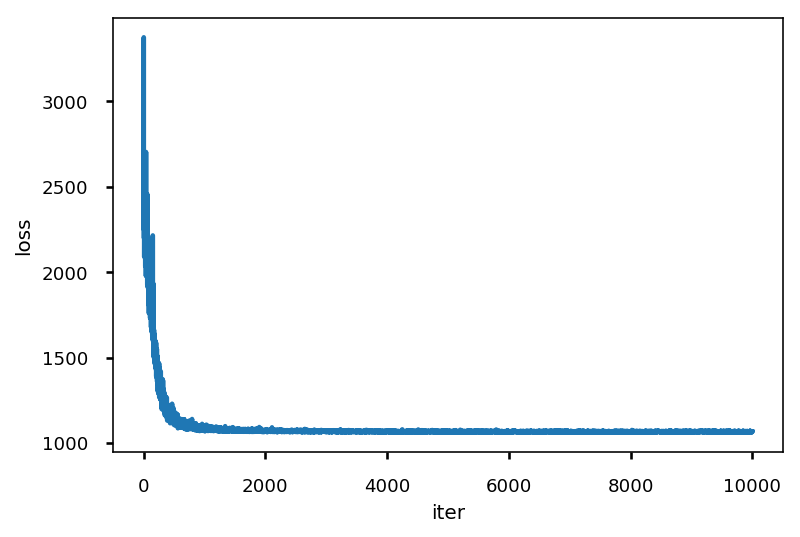

In [0]:
plt.plot(loss_);
plt.xlabel('iter');
plt.ylabel('loss');

In [0]:
graph_info = contextual_effect2._resolve_graph()
approx_param = dict()
for i, (rvname, param) in enumerate(graph_info[:-1]):
  approx_param[rvname] = {"mu": free_param[i][0].numpy(),
                          "cov_info": free_param[i][1].numpy()}

In [0]:
approx_param.keys()

dict_keys(['sigma_a', 'gamma', 'eps_a', 'b', 'sigma_y'])

In [0]:
approx_param['gamma']

{'cov_info': array([-3.56988324, -3.21251624, -2.67002341,  0.        ,  0.        ,
         0.        ]), 'mu': array([1.43109832, 0.68995023, 0.38283622])}

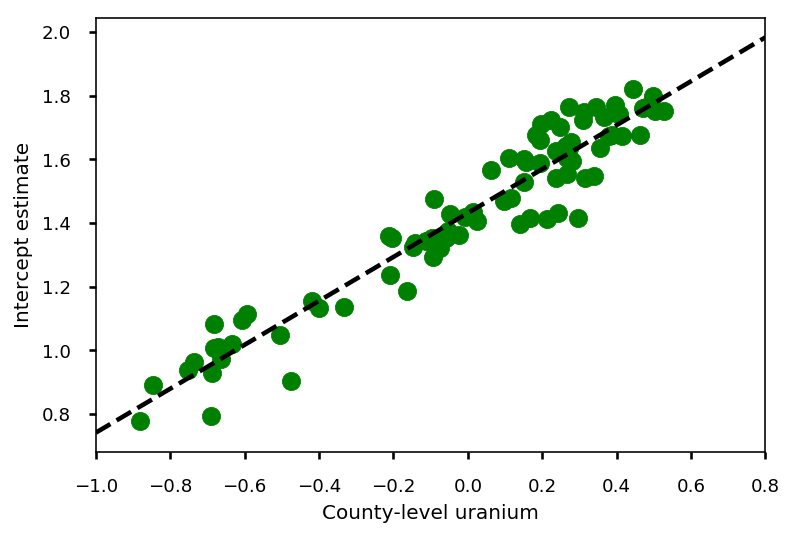

In [0]:
a_means = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
#          + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps_a']['mu'][county])
_, index = np.unique(county, return_index=True)
plt.scatter(u.values[index], a_means[index], color='g')

xvals = np.linspace(-1, 0.8)
plt.plot(xvals, 
         approx_param['gamma']['mu'][0]+approx_param['gamma']['mu'][1]*xvals, 
         'k--')
plt.xlim(-1, 0.8)

plt.xlabel('County-level uranium');
plt.ylabel('Intercept estimate');

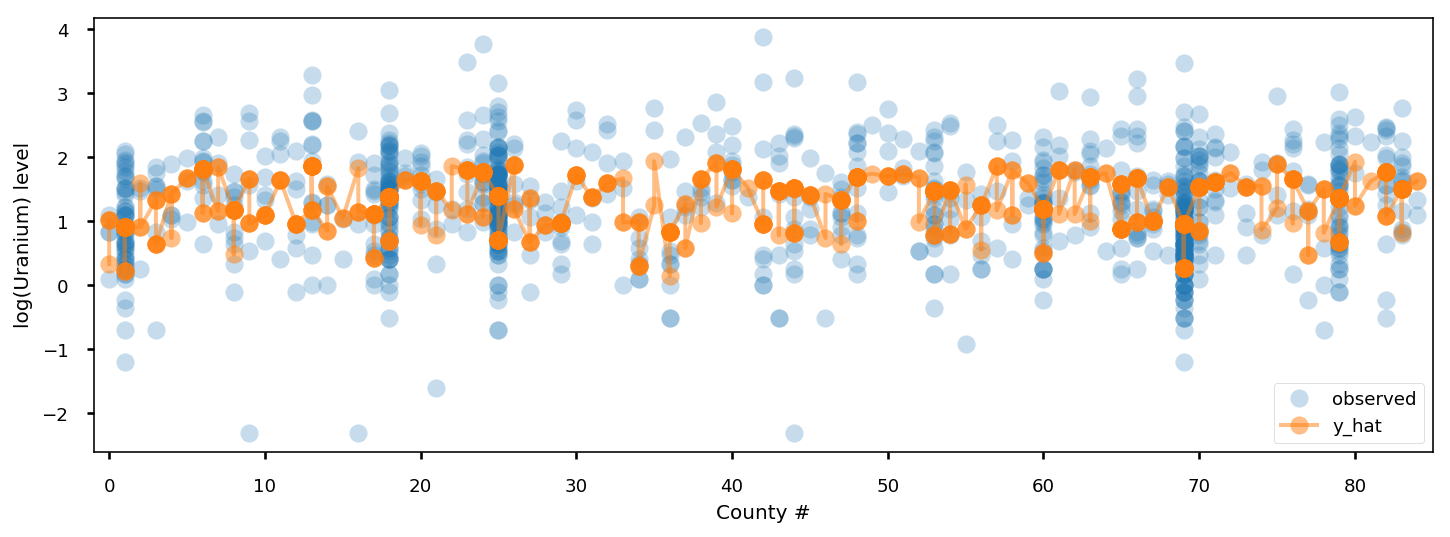

In [0]:
y_est = (approx_param['gamma']['mu'][0] 
         + approx_param['gamma']['mu'][1]*u.values
         + approx_param['gamma']['mu'][2]*xbar[county]
         + approx_param['eps_a']['mu'][county]
         + approx_param['b']['mu']*floor_measure)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(county, log_radon, 'o', alpha=.25, label='observed')
ax.plot(county, y_est, '-o', lw=2, alpha=.5, label='y_hat')
ax.set_xlim(-1, county.max()+1)
plt.legend(loc='lower right')
ax.set_xlabel('County #')
ax.set_ylabel('log(Uranium) level');

## Beta-Bernoulli Mixture Model

A mixture model where multiple reviewer labeling some items, with unknown (true) latent labels.

In [0]:
n = 50000    # number of examples reviewed
p_bad_ = 0.1 # fraction of bad events
m = 5        # number of reviewers for each example
rcl_ = .35 + np.random.rand(m)/10
prc_ = .65 + np.random.rand(m)/10

# PARAMETER TRANSFORMATION
tpr = rcl_
fpr = p_bad_*tpr*(1./prc_-1.)/(1.-p_bad_)
tnr = 1 - fpr

# broadcast to m reviewer.
batch_prob = np.asarray([tpr, fpr]).T
mixture = tfd.Mixture(
    tfd.Categorical(
        probs=[tf.cast(p_bad_, dtype),
               1-tf.cast(p_bad_, dtype)]),
    [
        tfd.Independent(tfd.Bernoulli(probs=tf.cast(tpr, dtype)), 
                        reinterpreted_batch_ndims=1),
        tfd.Independent(tfd.Bernoulli(probs=tf.cast(fpr, dtype)), 
                        reinterpreted_batch_ndims=1),
    ])
# Generate reviewer response
X_tf = mixture.sample([n])

# run once to always use the same array as input
# so we can compare the estimation from different
# inference method.
X_np = X_tf.numpy()

In [0]:
# batched Mixture model
mdl_mixture = tfd.JointDistributionSequential([
    # prc
    tfd.Independent(
        tfd.Beta(concentration1=tf.ones(m, dtype)*5., 
                 concentration0=2.),
        reinterpreted_batch_ndims=1,
    ), 
    # rcl prior
    tfd.Independent(
        tfd.Beta(concentration1=tf.ones(m, dtype)*2.,
                 concentration0=2.),
        reinterpreted_batch_ndims=1,
    ),
    # badness prior
    tfd.Beta(concentration1=tf.cast(1., dtype), 
             concentration0=10.),
    # likelihood
    #   We have a repeated measure at the end, and it could be quite difficult
    #   to get the shape right. Luckly we have a new shape handling distribution
    #   wrapper to do that: tfd.Sample
    lambda p_bad, rcl, prc: tfd.Sample(tfd.Mixture(
        tfd.Categorical(
            probs=tf.transpose(tf.concat(([p_bad], [1-p_bad]), axis=0))
        ),
        [
            tfd.Independent(
                tfd.Bernoulli(probs=rcl), 
                reinterpreted_batch_ndims=1
            ),
            tfd.Independent(
                tfd.Bernoulli(
                    probs=p_bad[:, None]*rcl*(1./prc-1.)/(1.-p_bad[:, None])),
                reinterpreted_batch_ndims=1
            )
        ]
    ), (n, )), 
])

mdl_mixture._resolve_graph()

(('prc', ()), ('rcl', ()), ('p_bad', ()), ('x', ('p_bad', 'rcl', 'prc')))

In [0]:
prc, rcl, p_bad, x = mdl_mixture.sample(4)

In [0]:
mdl_mixture.log_prob_parts([prc, rcl, p_bad, X_np[np.newaxis, :, :]])

(<tf.Tensor: id=667, shape=(4,), dtype=float64, numpy=array([3.61274191, 1.37071057, 3.96599377, 1.97902739])>,
 <tf.Tensor: id=684, shape=(4,), dtype=float64, numpy=array([ 1.20969683,  1.27086003,  1.56400773, -0.73048954])>,
 <tf.Tensor: id=699, shape=(4,), dtype=float64, numpy=array([2.07638812, 2.24359192, 1.64708251, 2.26041473])>,
 <tf.Tensor: id=772, shape=(4,), dtype=float64, numpy=array([-57360.74671334, -64463.01252342, -49718.1302193 , -71160.1710762 ])>)

#### Inference (HMC)

In [0]:
# Define a closure over our joint_log_prob. Note also that we are using the
# batched version logp function to have multi-chain sampling
@tf.function(autograph=False)
def run_chain(number_of_steps = 1000, burnin = 5000, nchain = 4):
  # Set the chain's start state.
  prc, rcl, p_bad, _ = mdl_mixture.sample(nchain)
  initial_chain_state = [prc, rcl, p_bad]

  # Since MCMC operates over unconstrained space, we need to transform the
  # samples so they live in real-space.
  unconstraining_bijectors = [
      tfb.Sigmoid(),       # Maps R to [0, 1].
      tfb.Sigmoid(),       # Maps R to [0, 1].
      tfb.Sigmoid(),       # Maps R to [0, 1].
  ]

  def trace_fn(_, pkr):
    return (pkr.inner_results.inner_results.is_accepted,
            pkr.inner_results.inner_results.accepted_results.step_size)

  kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=lambda prc, rcl, p_bad: mdl_mixture.log_prob(
          [prc, rcl, p_bad, X_np[np.newaxis, :, :]]),
      num_leapfrog_steps=3,
      step_size=[tf.cast(i, dtype=dtype) for i in [1e-3, 1e-3, 1e-3]]),
    bijector=unconstraining_bijectors)

  hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    kernel,
    target_accept_prob=tf.cast(.8, dtype=dtype),
    # Adapt for the entirety of the trajectory.
    num_adaptation_steps=burnin
    )

  # Sampling from the chain.
  mcmc_trace, (is_accepted, step_size) = tfp.mcmc.sample_chain(
      num_results = number_of_steps,
      num_burnin_steps = burnin,
      current_state=initial_chain_state,
      kernel=hmc,
      trace_fn=trace_fn)

  return mcmc_trace, is_accepted, step_size

# Sample from posterior distribution and get diagnostic
mcmc_trace, is_accepted, step_size = run_chain()
ess = tfp.mcmc.effective_sample_size(mcmc_trace)
rhat = tfp.mcmc.potential_scale_reduction(mcmc_trace)

In [0]:
print("acceptance rate: {}".format(is_accepted.numpy().mean()))
print("final 100 step size: {}".format(np.asarray(step_size[-100:]).mean(-1)))
print("The effective sample size is: ")
pprint([es.numpy() for es in ess])
print("The rhat is: ")
pprint([r.numpy() for r in rhat])

acceptance rate: 0.80825
final 100 step size: [0.01410865 0.01410865 0.01410865]
The effective sample size is: 
[array([[ 67.40142788,  64.98877826,  63.66718171,  57.1963031 ,
         48.90152956],
       [ 90.97014763,  71.23093438,  67.23412695,  69.52659988,
        102.13200247],
       [ 84.03904766, 127.77891108,  95.63002733,  73.79918668,
         48.40533856],
       [ 42.86758148,  50.76312308,  19.56420644,  42.03983394,
         57.33400113]]),
 array([[ 64.14306365, 128.94649518,  65.38484007, 132.73437058,
        107.13056501],
       [ 93.37600163,  86.92328406, 131.1253347 , 104.36159822,
        112.64122799],
       [139.80713822, 122.83259676, 136.06478487, 130.25628073,
        130.51801093],
       [119.61009653,  88.9124995 ,  26.92947935,  94.20526093,
         67.84508549]]),
 array([37.52894877, 55.2402814 , 50.25382802, 14.96355857])]
The rhat is: 
[array([1.01610638, 1.01923701, 1.00510796, 1.00943287, 1.00294767]),
 array([1.00280864, 1.00392913, 1.026896

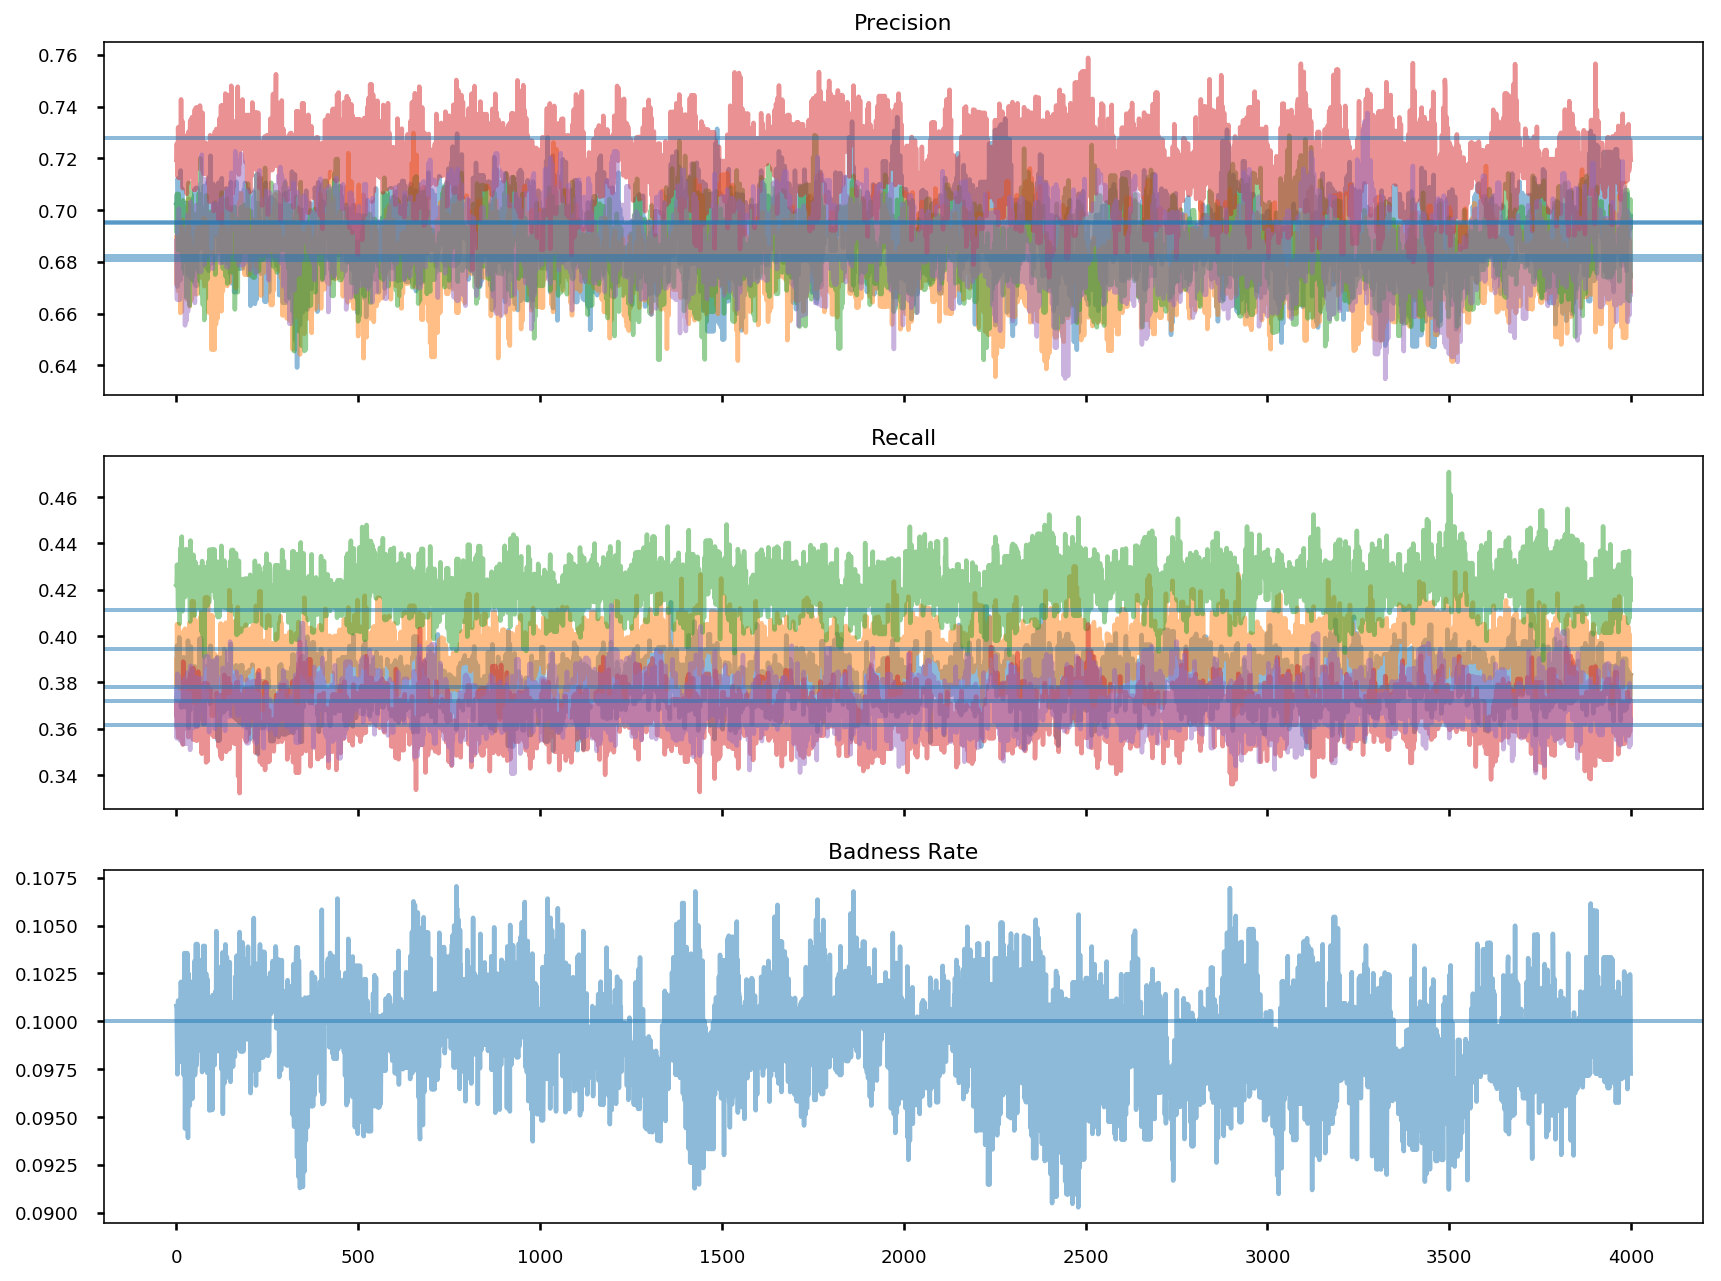

In [0]:
var_name = ['Precision', 'Recall', 'Badness Rate']
true_val = [prc_, rcl_, [p_bad_]]
n_var = len(mcmc_trace)
_, ax = plt.subplots(n_var, 1, figsize=(12, 3*n_var), sharex=True)
for i in range(n_var):
  trace_val = mcmc_trace[i].numpy()
  if trace_val.ndim > 2:
    trace_val = trace_val.reshape(-1, trace_val.shape[-1])
  else:
    trace_val = trace_val.flatten()
  ax[i].plot(trace_val, alpha=.5)
  [ax[i].axhline(k, lw=2, alpha=.5) for k in true_val[i]]
  ax[i].set_title(var_name[i])
plt.tight_layout();